In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# GM0 Performance Evaluation

**IMPORTANT**: This notebook should be used as a base for the evaluation of different models. 

- Please **make a copy of this notebook** whenever you want to evaluate a model. Load the desired model by changing the following `model_path_str` variable. 
- This notebook is currently not saving any generated plot. Please make sure to not overwrite the outputs, or to save the plots whenever needed. 
- This notebook saves the generated data. Please refer to the Evaluation section of this notebook. 

Available models on the SDSC shared folder: 

In [3]:
!ls /store/sdsc/sd28/models/GM0/diffusion/

1D-UNET-DDPM-envelope
consistency-model-1D_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05
ddim-1D_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05
ddim-pred:epsilon-1D_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05
ddim-pred:epsilon-1D_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-downsampling:1_LogSpectrogram-{}
ddim-pred:sample-1D-downsampling:1_SignalWithEnvelope-first_order_lp-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-downsampling:1_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-downsampling:1_SignalWithEnvelope-moving_average-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-downsampling:2_LogSpectrogram-{}
ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-first_order_lp-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-dow

In [4]:
dataset_folder = "../outputs"

One can either choose a specific checkpoint of a model or the most recent checkpoint of that model (default):

In [5]:
# Pick the last checkpoint of the model
model_path_str = dataset_folder + "/ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-moving_average_shifted-log-log_offset:1.0e-05-normalize-scalar:True"

# Or pick a specific checkpoint
# model_path_str = dataset_folder + "/ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-moving_average_shifted-log-log_offset:1.0e-05-normalize-scalar:True/name=0_epoch=125-val_loss=0.02.ckpt"

Import the needed libraries, modules and needed variables

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os

from pathlib import Path
from tqdne.utils import *
from tqdne.conf import Config
from tqdne.metric import *

/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.empty_cache()
else: 
    device = torch.device('cpu')

torch.cuda.is_available(), device

(True, device(type='cuda'))

In [8]:
config = Config()

# Select the signal length
signal_length = config.signal_length 

# Set the number of channels of the desired output signal  
n_channels = config.num_channels

# Set the sampling frequency
fs = config.fs

# Set the conditioning parameters range
cond_params_range = config.conditional_params_range

Load the model

2024-04-15 13:04:43 - root - INFO - Last checkpoint is : ../outputs/ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-moving_average_shifted-log-log_offset:1.0e-05-normalize-scalar:True/name=0_epoch=143-val_loss=0.02.ckpt
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


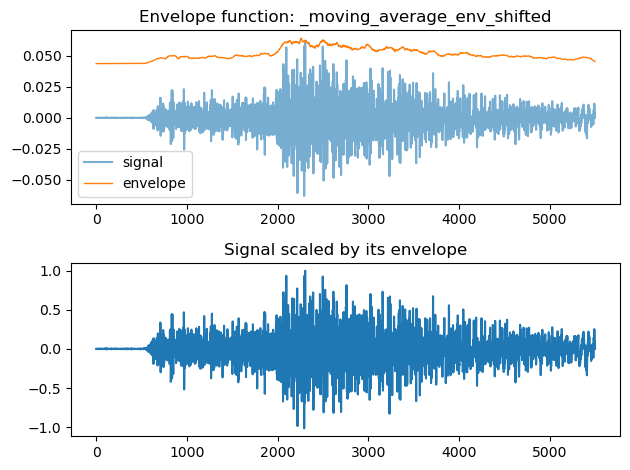

Model: LightningDiffusion
Number of learnable parameters: 9704198
Model size: 117.02 MB
UNet scheme: 
 base num. channels: 32 
 channel multipliers (down/up blocks): (1, 2, 4, 8) 
 num. ResBlocks per down/up block: 2 
 use Attention: True 
 conv. kernel size: 5 
Diffusion prediction type: sample
Learning rate schedule: 
 start: 0.0003 
 scheduler: cosine 
 warmup steps: 500
Batch size: 128
Downsampling factor: 2. The model was trained on signals with length 2736, as the sampling rate used was 50 instead of 100
Data representation shape: (1, 6, 5472) (batch_size, channels, signal_length)
Data representation name: SignalWithEnvelope
ckpt file: ../outputs/ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-moving_average_shifted-log-log_offset:1.0e-05-normalize-scalar:True/name=0_epoch=143-val_loss=0.02.ckpt


In [9]:
model, model_data_repr, ckpt = load_model(Path(model_path_str), use_ddim=False)
model.to(device)
model.eval()
print_model_info(model, model_data_repr, ckpt)

Let's generate a batch of data

In [10]:
# Select the batch size.
batch_size = model.hparams.optimizer_params.batch_size

# One can also choose the batch size
# batch_size = 32

batch_size

128

In [11]:
# Insert values for the conditional input parameters.
# Please read generate_cond_inputs documentation (in utils.py) to understand the structure of cond_input_params dictionary
cond_input_params = {
    "hypocentral_distance": [10, 100, 150],
    "is_shallow_crustal": [0],
    "magnitude": [5.5, 4, 7, 8.5],
    "vs30": None,
}

data_raw = generate_data(model, model_data_representation=model_data_repr, raw_output=True, num_samples=batch_size, cond_input_params=cond_input_params, device=device.type, max_batch_size=batch_size)
data_raw['waveforms'].shape, data_raw['cond'].shape

100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


((128, 6, 5472), (128, 4))

In [12]:
data_raw_wf = data_raw['waveforms']
data_raw_wf.shape

(128, 6, 5472)

In [13]:
data_wf = model_data_repr.invert_representation(data_raw_wf)
data_wf.shape

(128, 3, 5472)

## Single Sample Visualization

Let's investigate model's raw output 

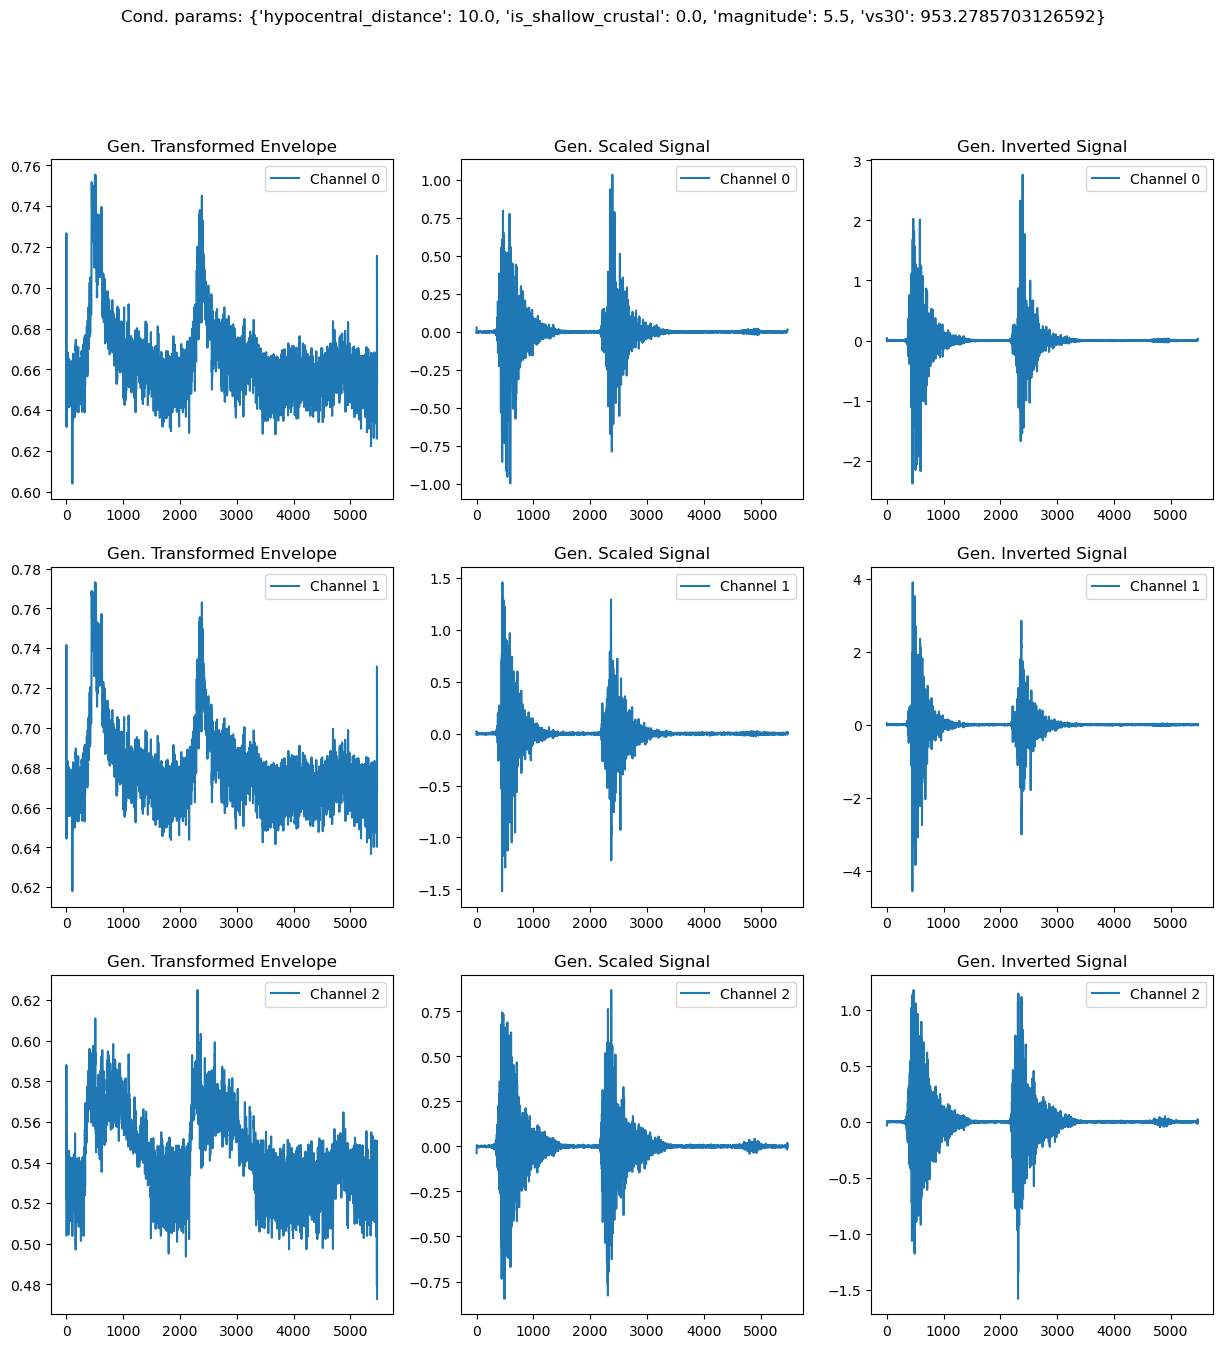

In [14]:
sample_index = 0
plot_raw_waveform(data_raw_wf[sample_index], data_raw['cond'][sample_index], model_data_repr, data_wf[sample_index])

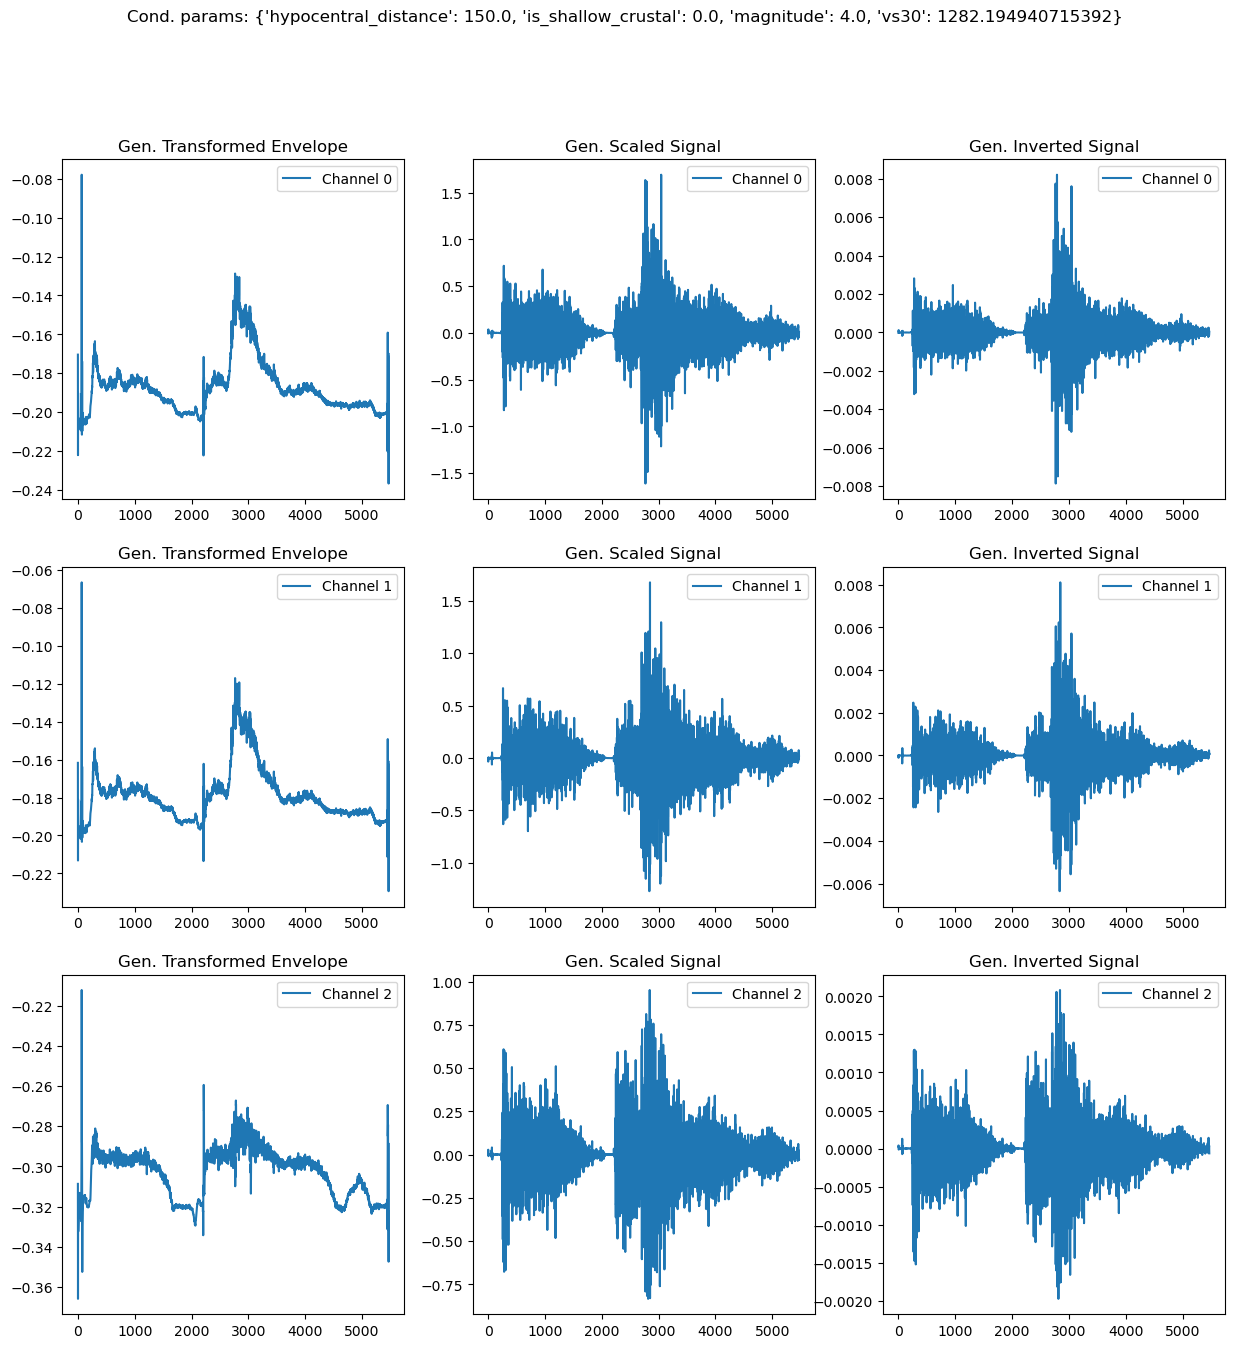

In [15]:
sample_index = 3
plot_raw_waveform(data_raw_wf[sample_index], data_raw['cond'][sample_index], model_data_repr, data_wf[sample_index])

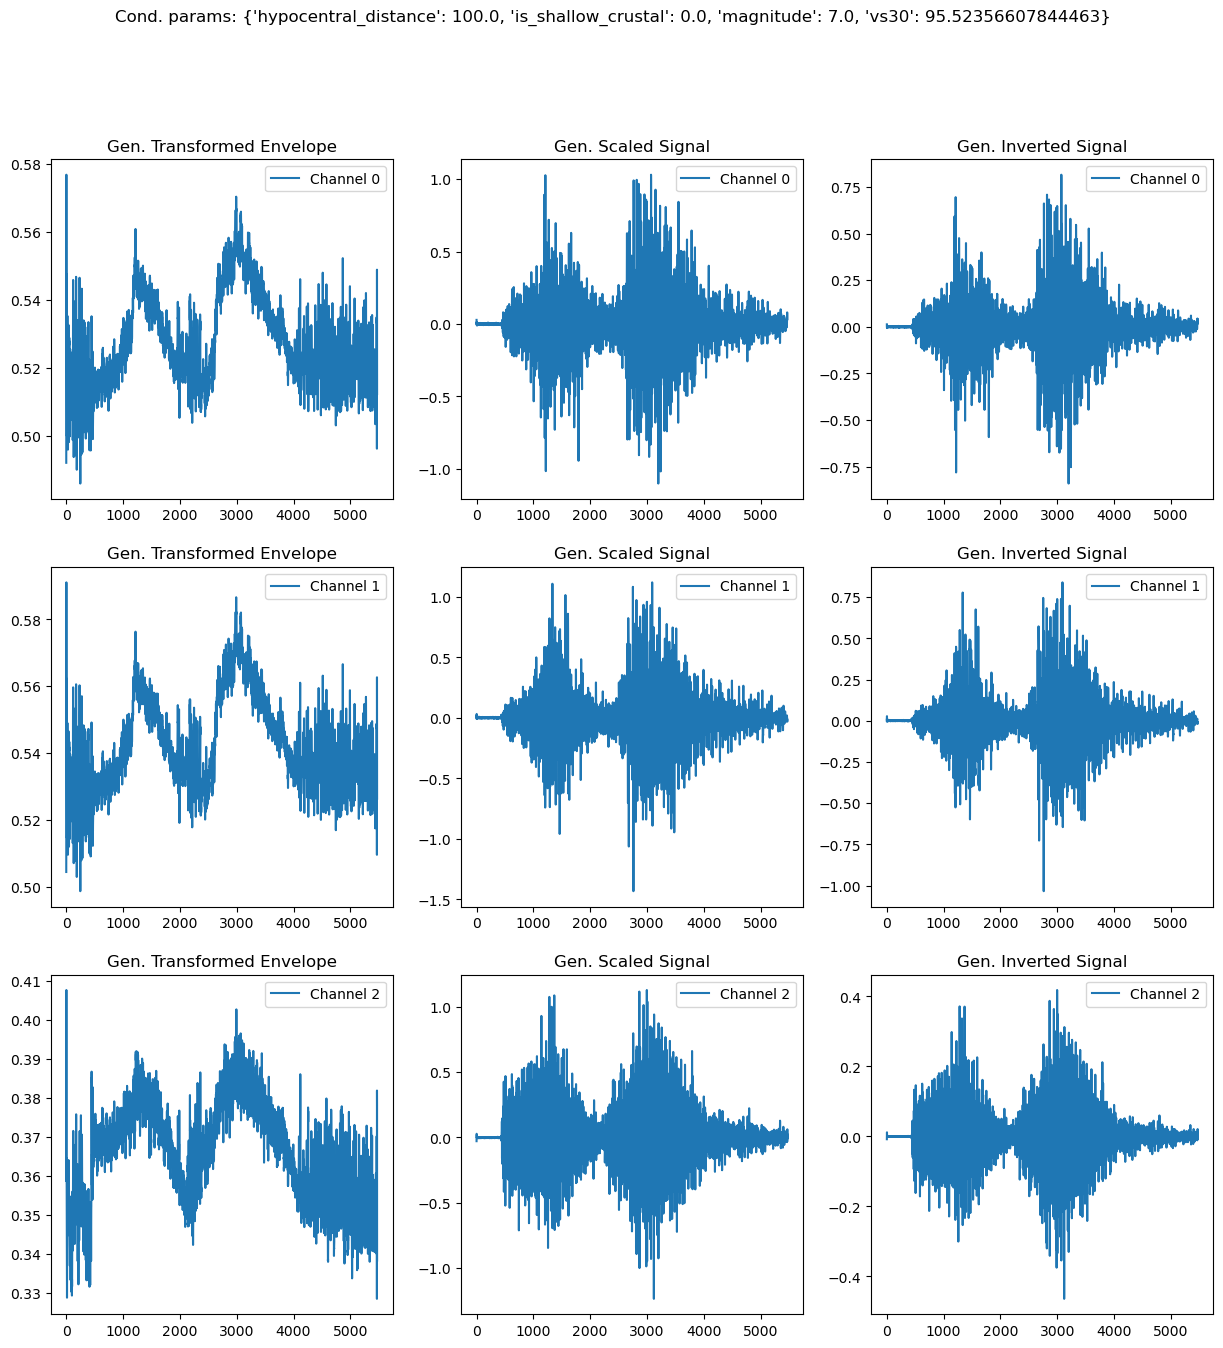

In [16]:
sample_index = 10
plot_raw_waveform(data_raw_wf[sample_index], data_raw['cond'][sample_index], model_data_repr, data_wf[sample_index])

In [17]:
# TODO: works only for 1D signals, need to generalize to 2D signals. However, is only useful for 1D signals.
# max_peak_index = np.argmax(np.max(np.abs(data_raw_wf), axis=(1, 2)))
# plot_raw_waveform(data_raw_wf[max_peak_index], n_channels, data_wf[max_peak_index])

Let's now see the generated waveforms, along with their Power Spectral Density and Log Envelope. 

In [18]:
data = {"waveforms": data_wf, "cond": data_raw['cond']}

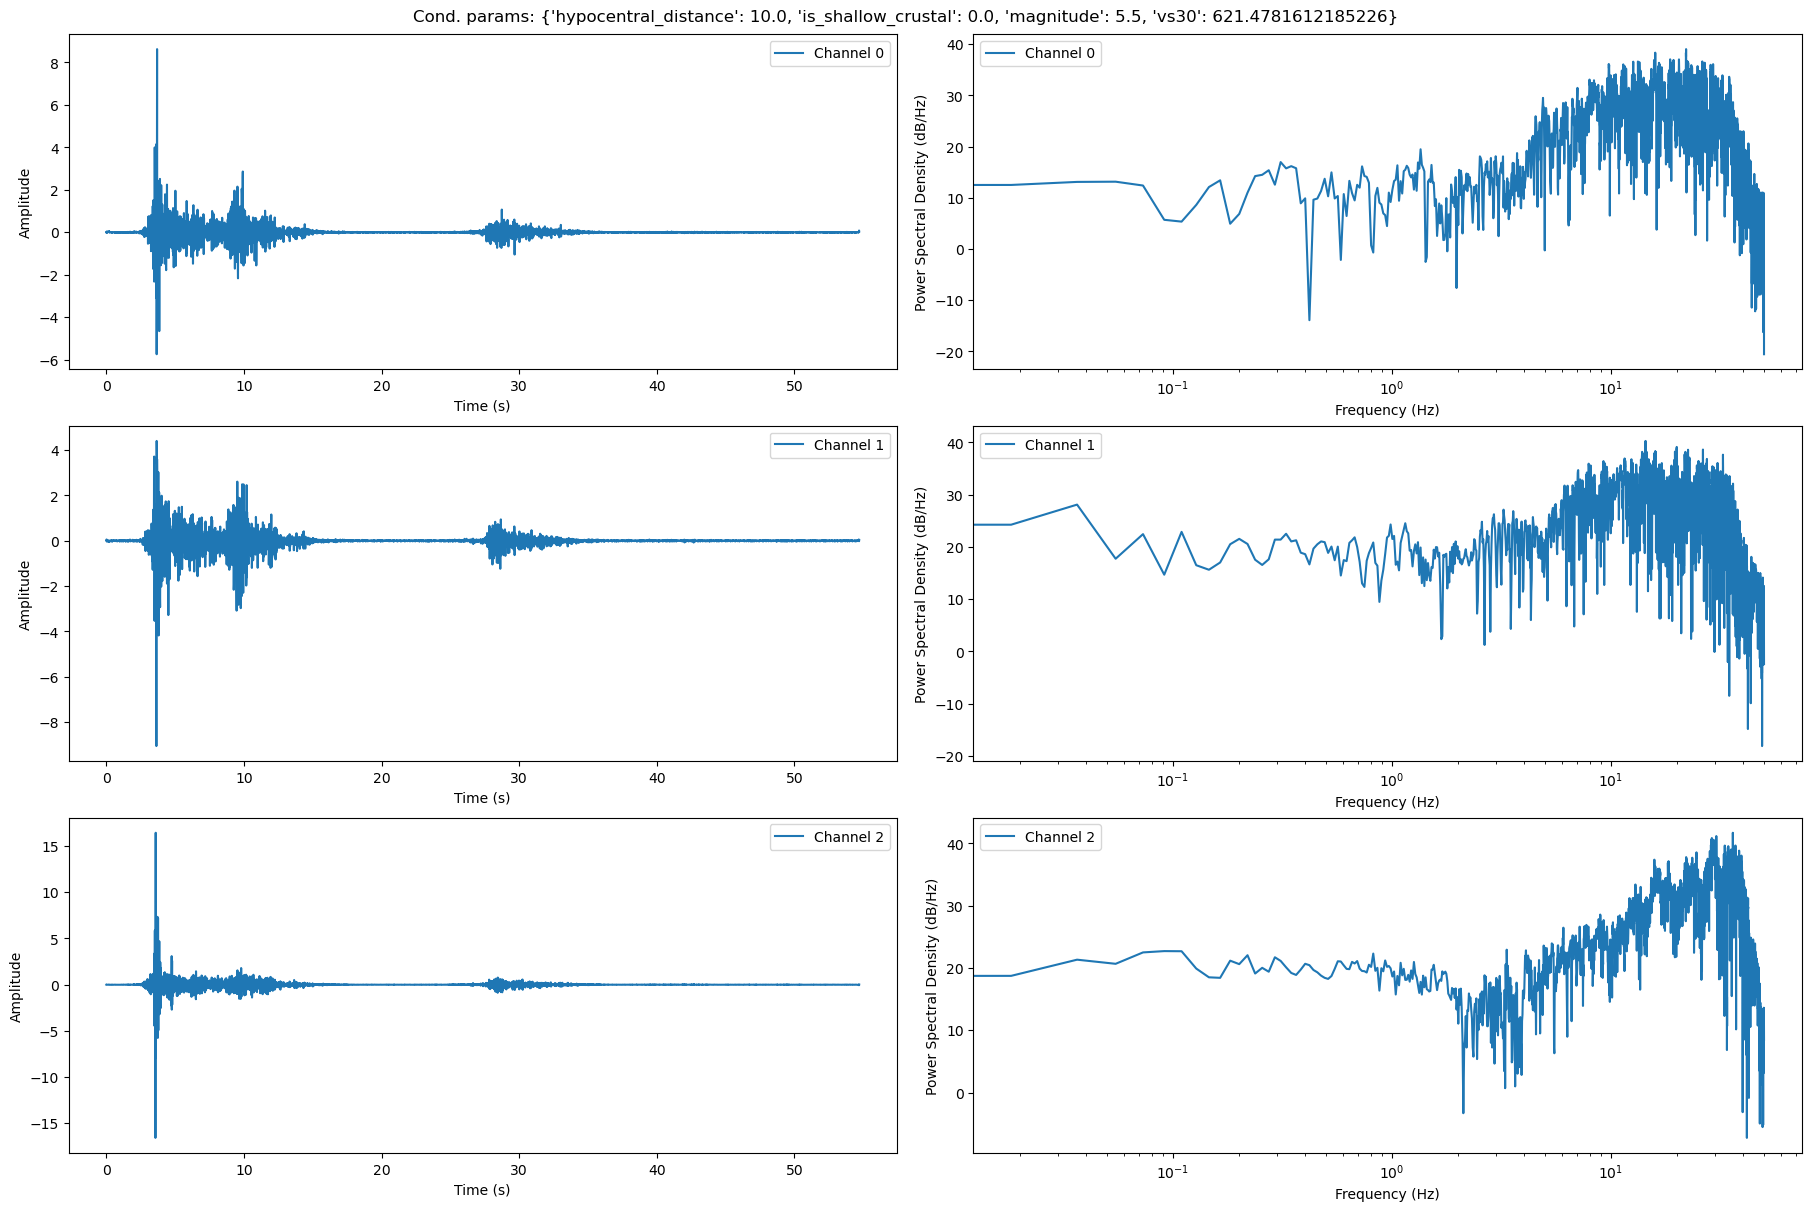

In [19]:
plot_waveform_and_psd(get_samples(data, num_samples=1))

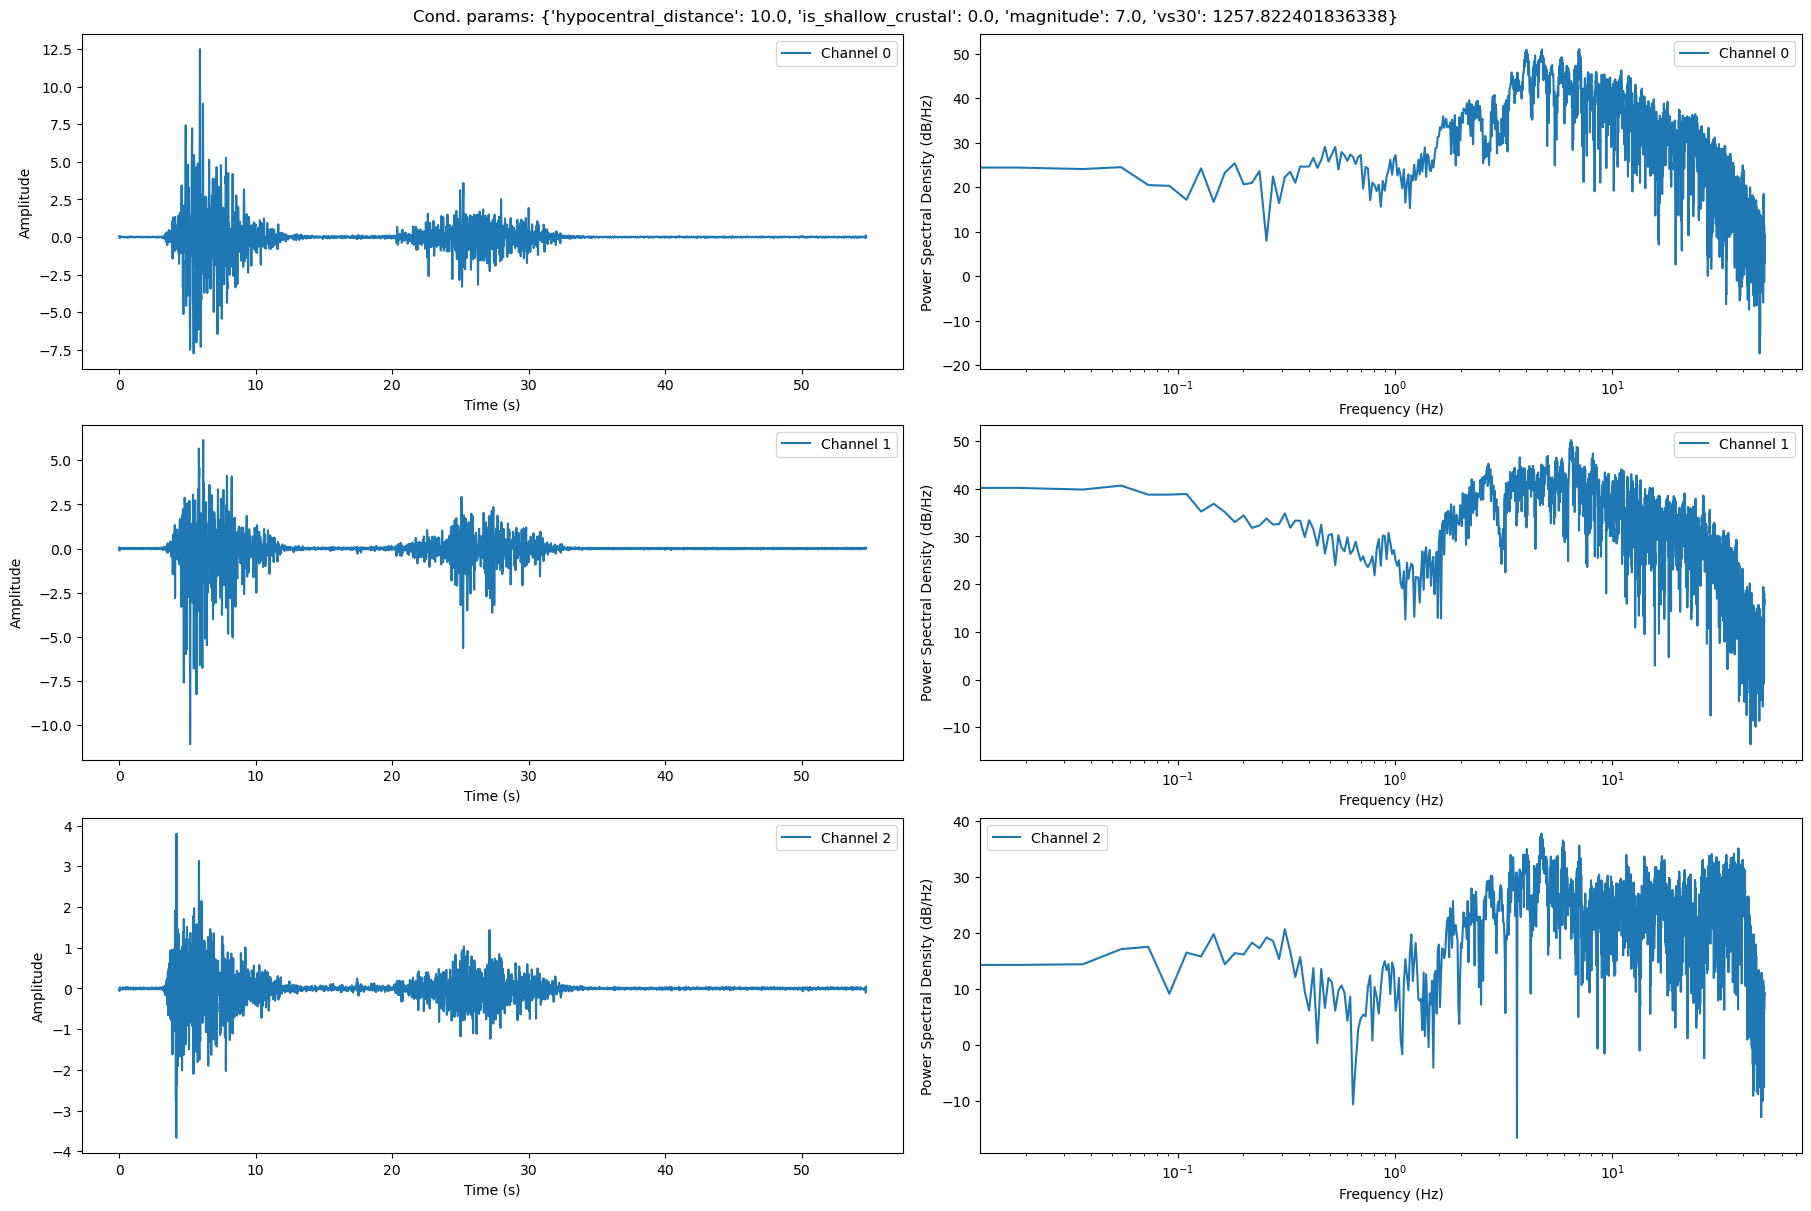

In [20]:
plot_waveform_and_psd(get_samples(data, indexes=[2]))

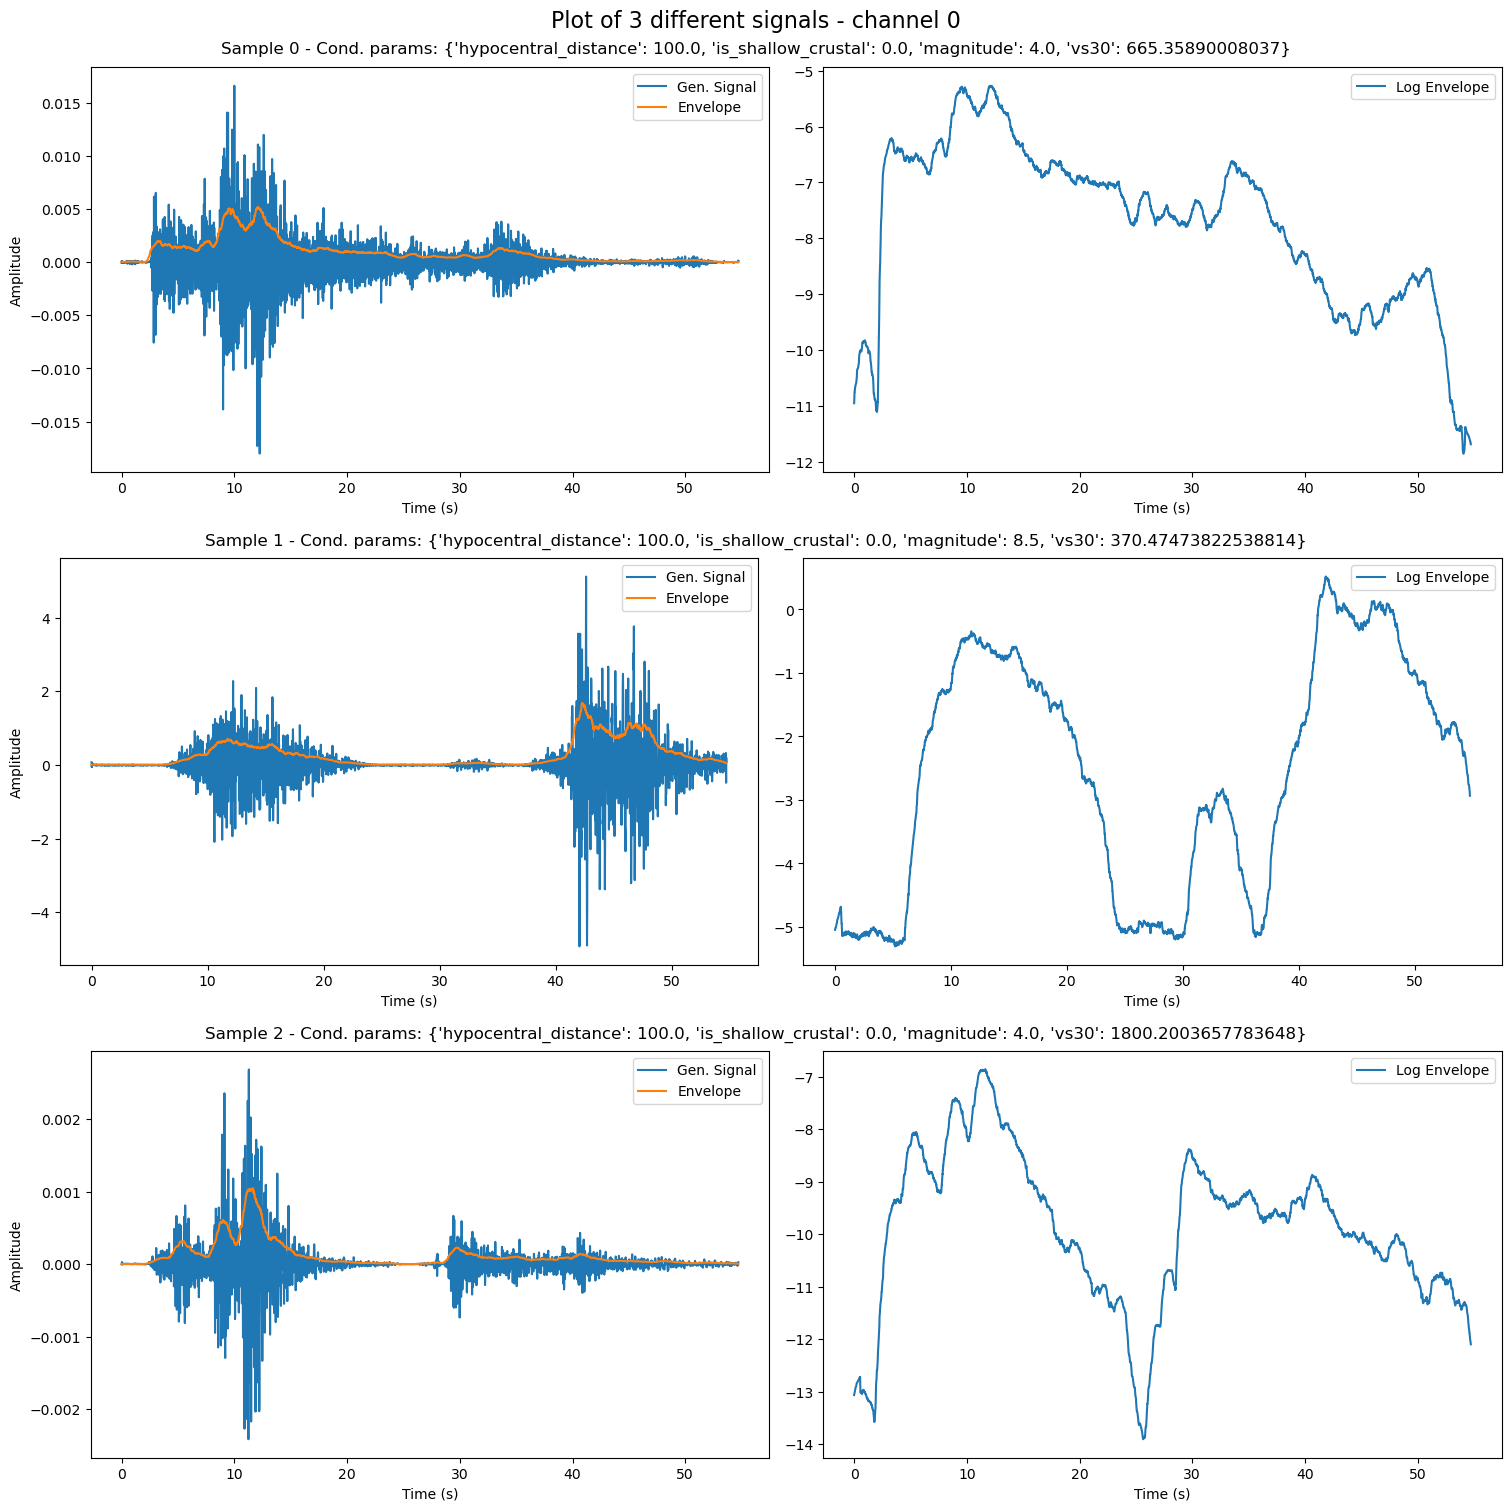

In [21]:
plot_waveforms(get_samples(data, num_samples=3), channel_index=0, plot_log_envelope=True)

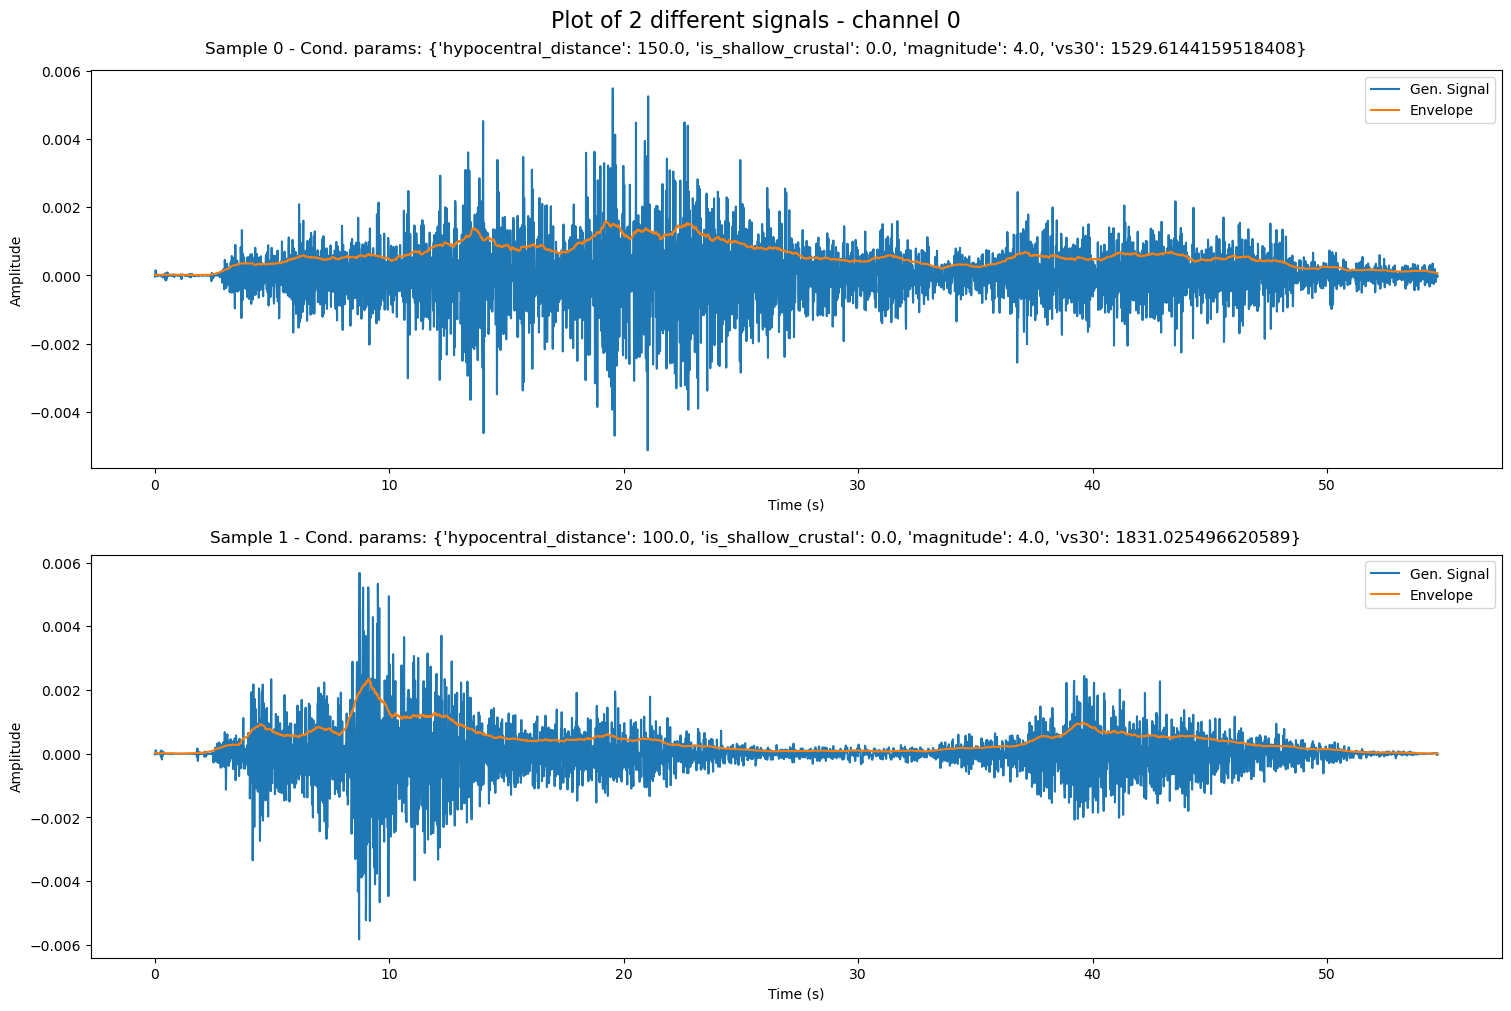

In [22]:
plot_waveforms(get_samples(data, num_samples=2), channel_index=0, plot_log_envelope=False)

## Batch Statistics

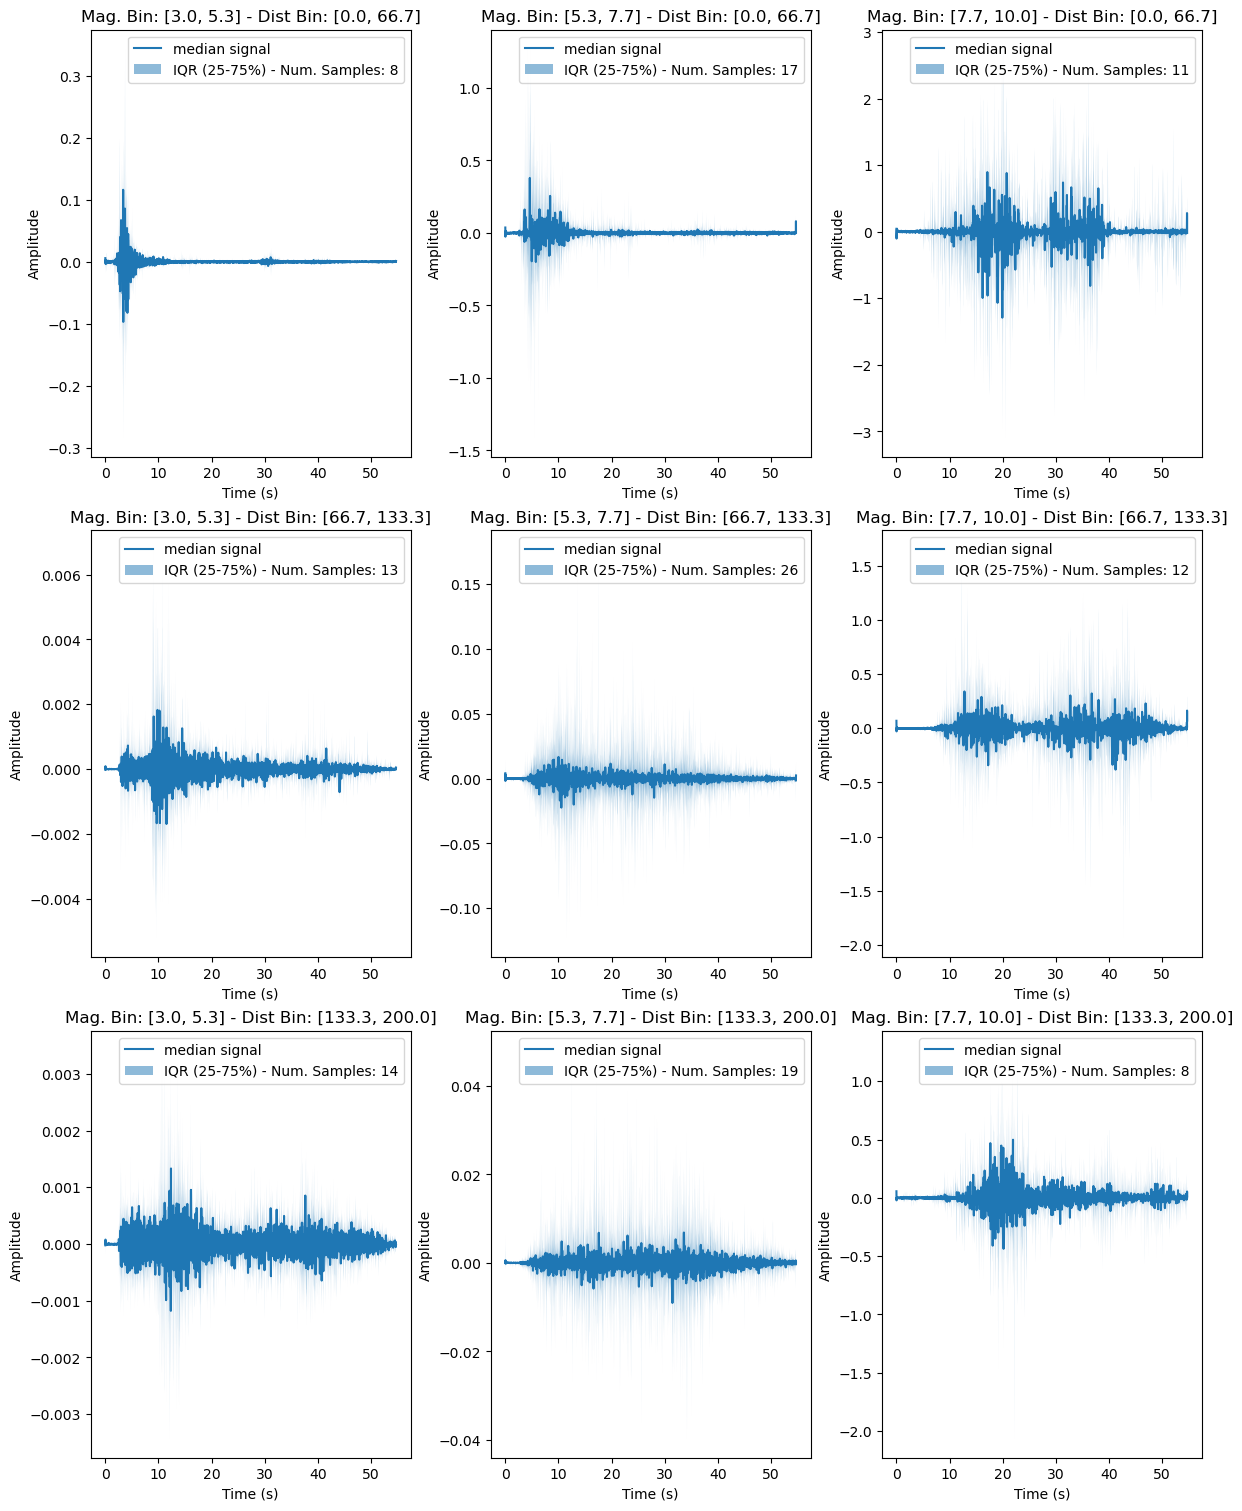

In [23]:
plot_by_bins(data, num_magnitude_bins=3, num_distance_bins=3, plot_type='waveform')

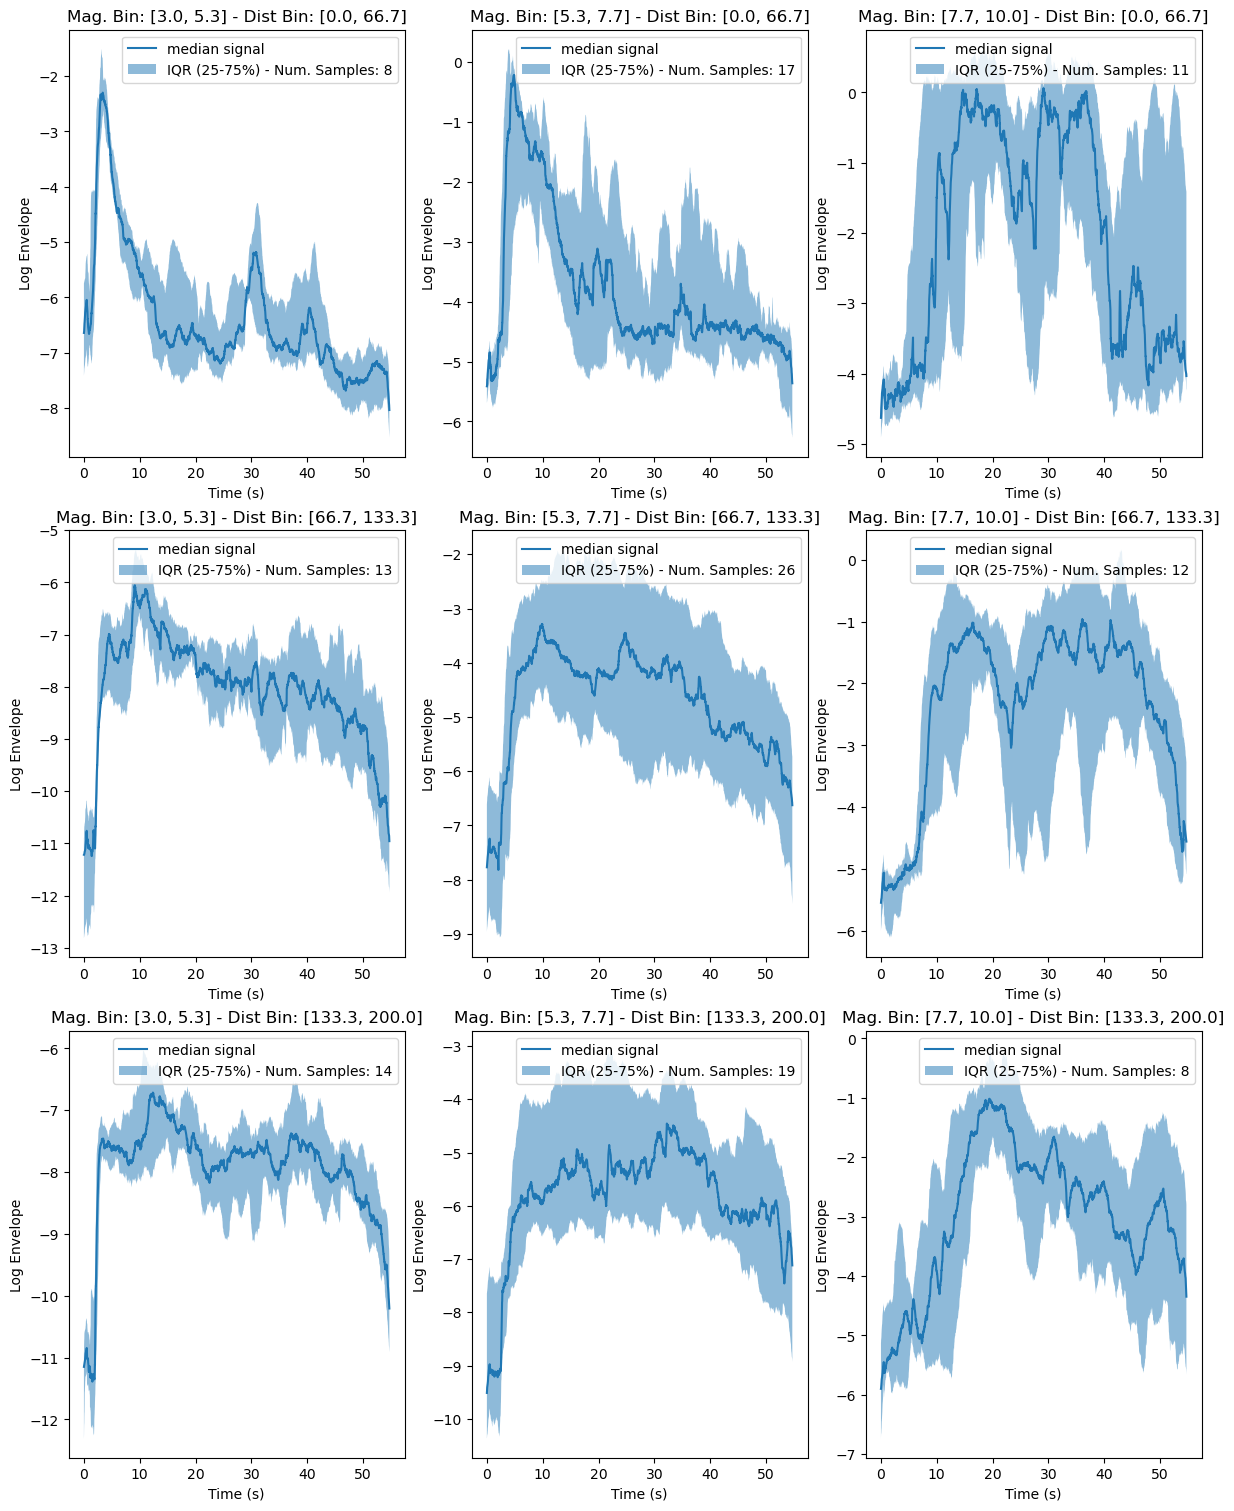

In [24]:
plot_by_bins(data, num_magnitude_bins=3, num_distance_bins=3, plot_type='log_envelope')

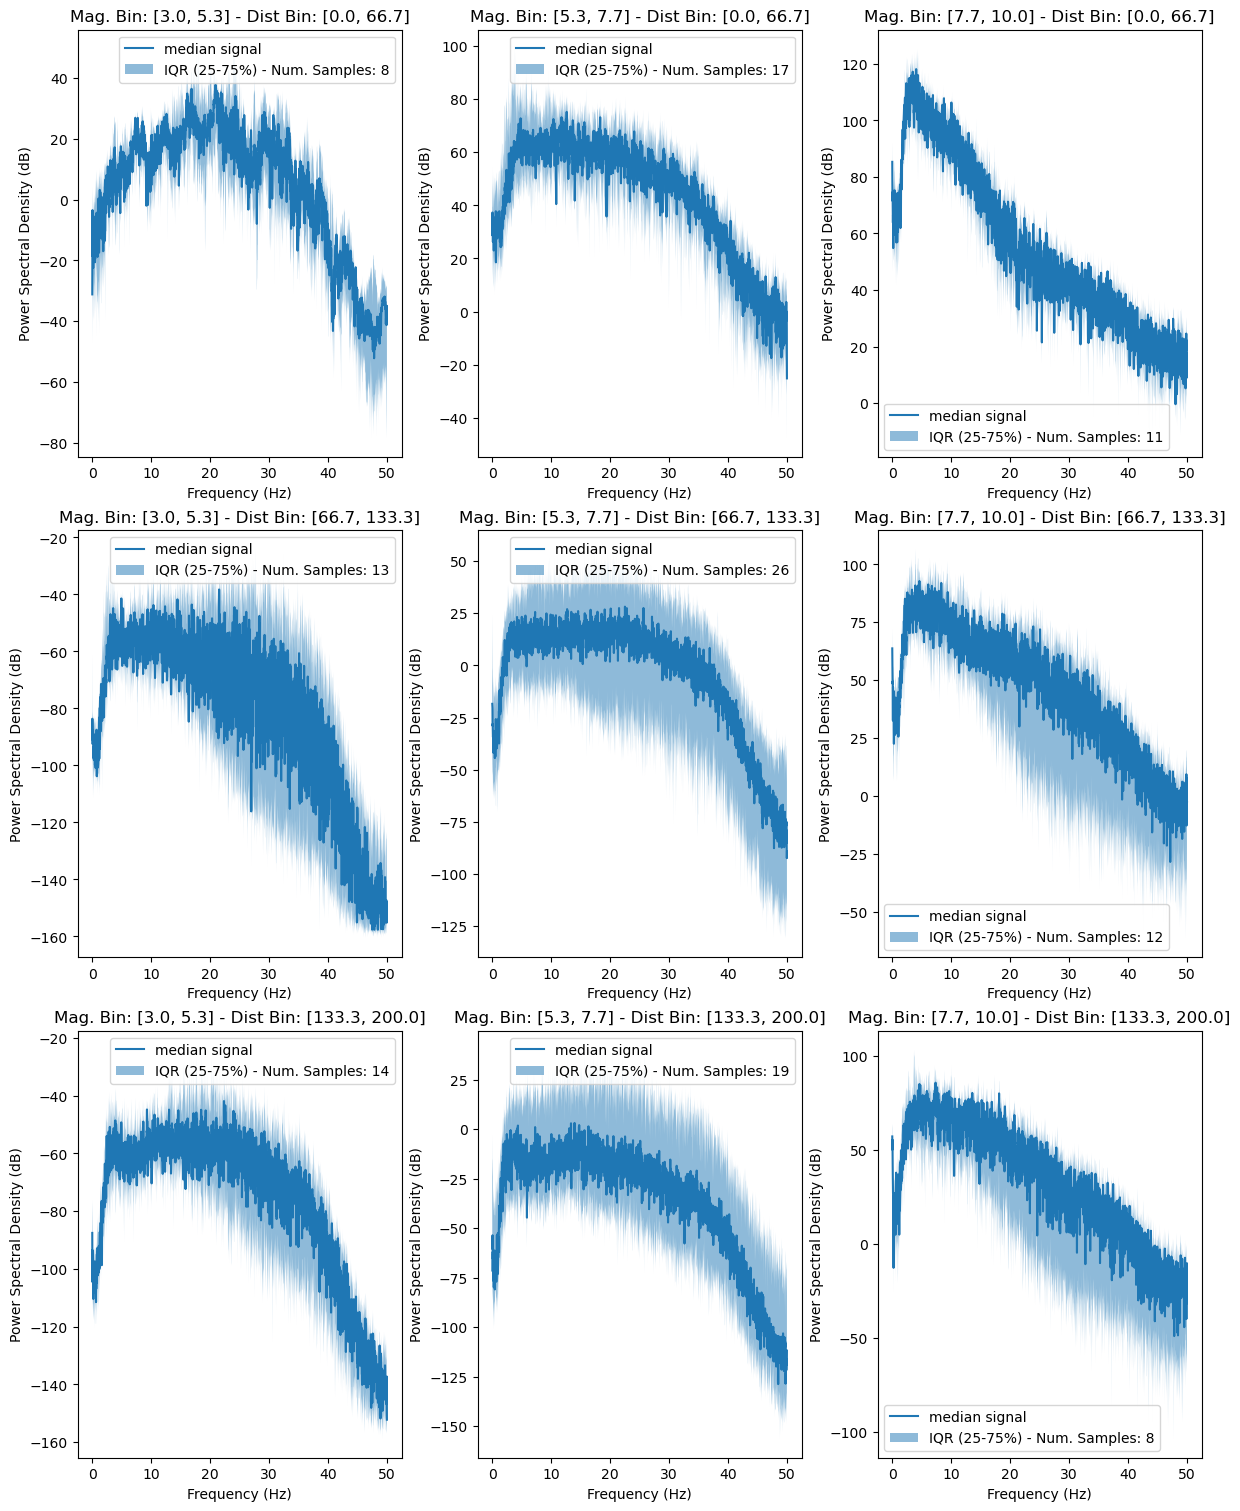

In [25]:
plot_by_bins(data, num_magnitude_bins=3, num_distance_bins=3, plot_type='power_spectral_density')

## Evaluation

In [26]:
from tqdne.dataset import EnvelopeDataset
from torch.utils.data import DataLoader

test_dataset_path = config.datasetdir / config.data_test
test_dataset = EnvelopeDataset(test_dataset_path, model_data_repr, config.signal_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Let's generate couple of samples with the same conditioning parameters to check the expressiveness of the model and check if it stay within the true data distribution. 

100%|██████████| 100/100 [00:04<00:00, 22.39it/s]


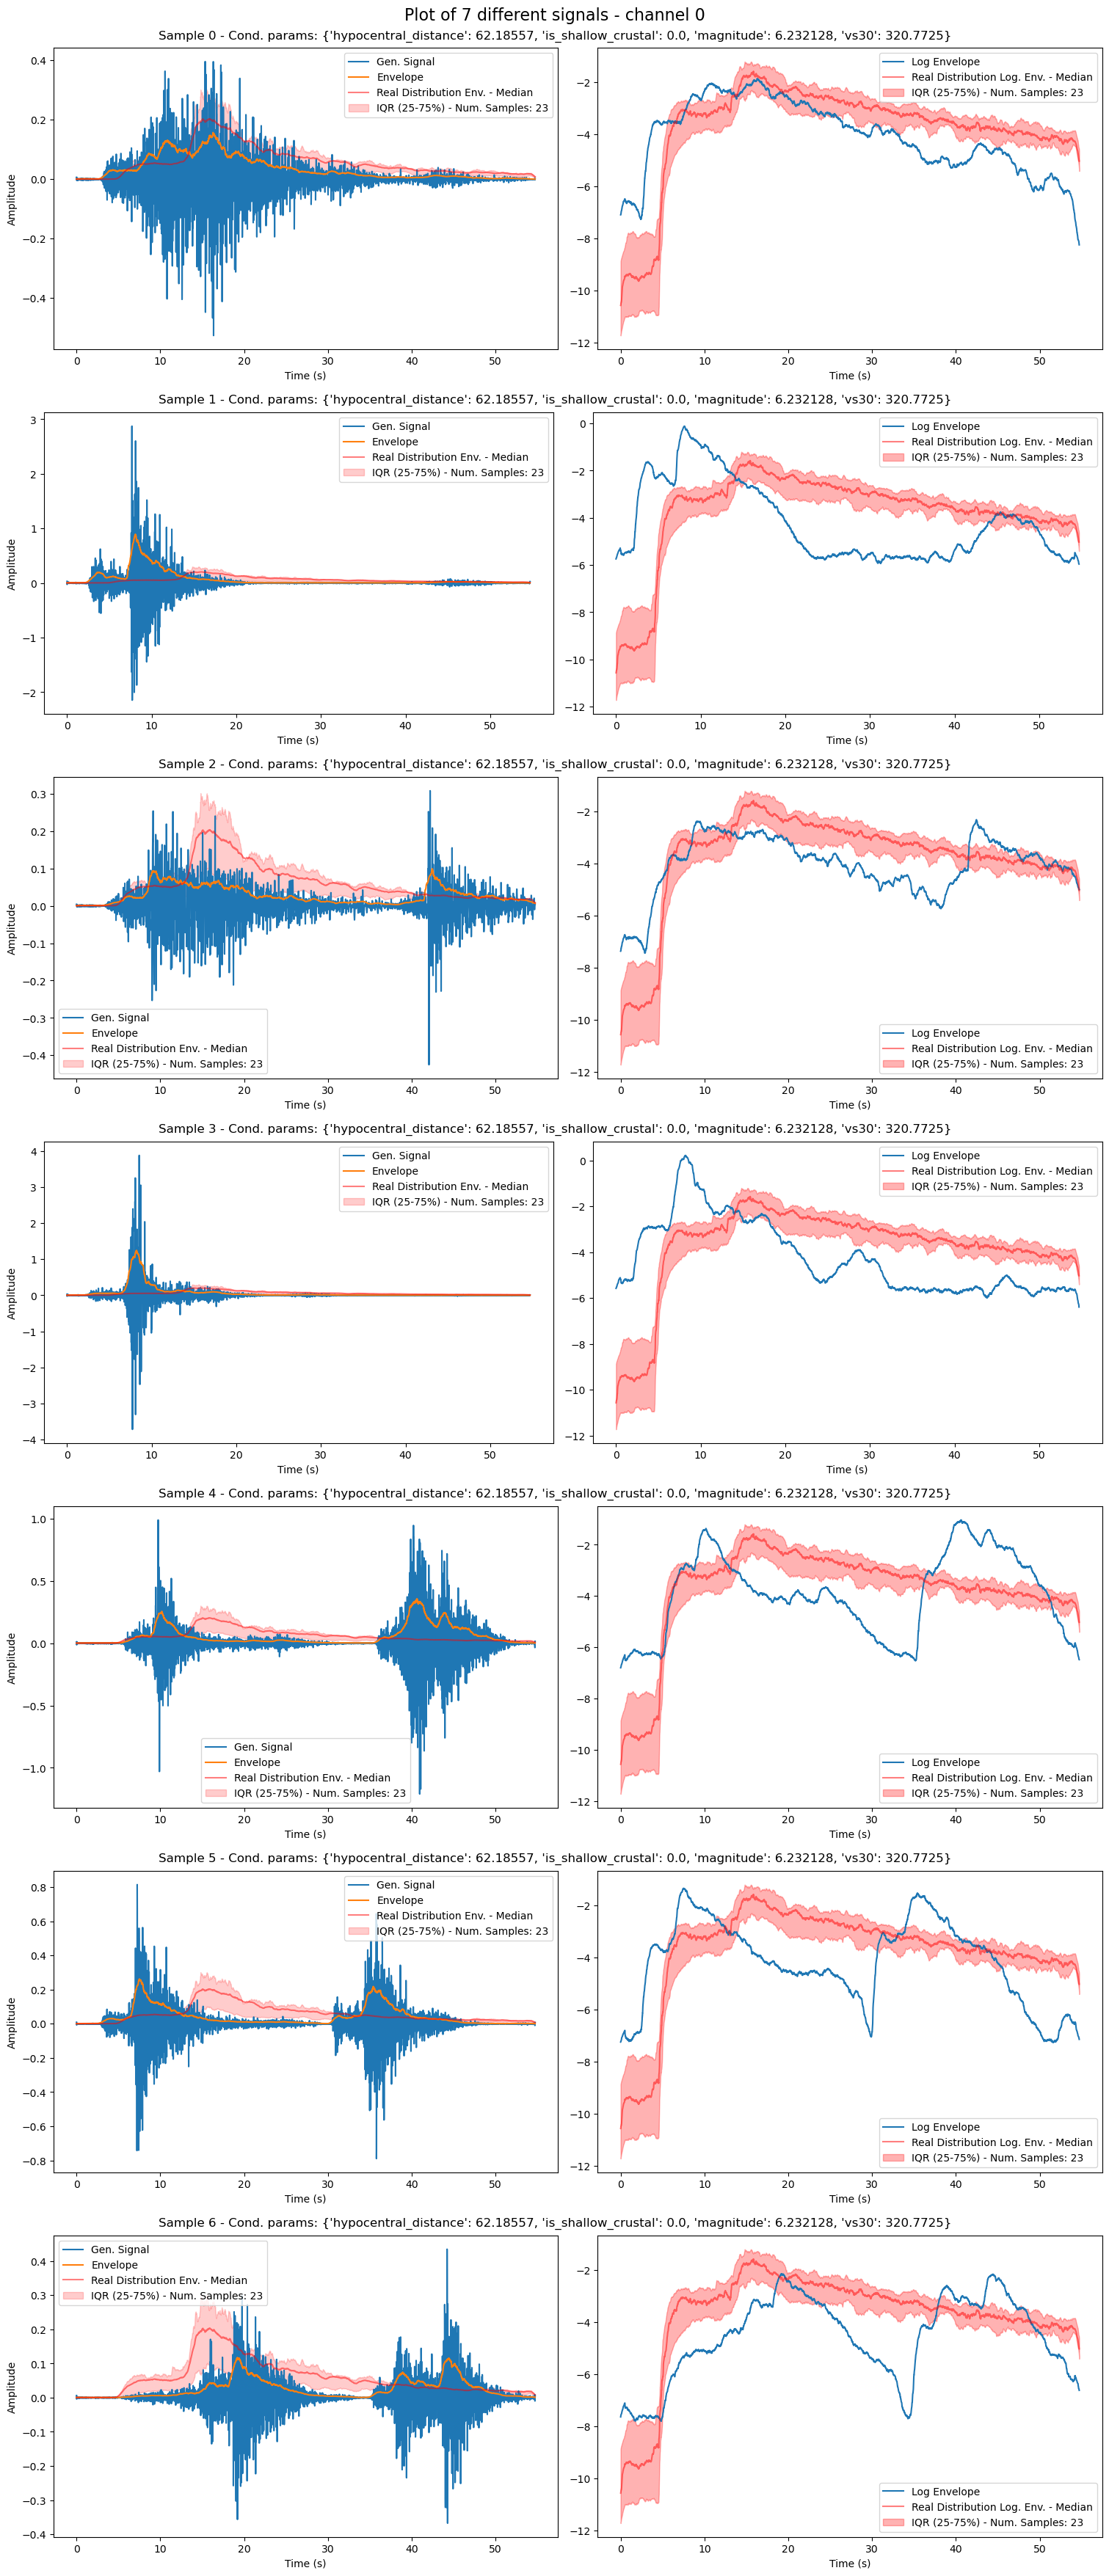

In [27]:
mag_bin = (6, 6.5)
dist_bin = (50, 70)
data_test_single_bin = test_dataset.get_data_by_bins(mag_bin, dist_bin, is_shallow_crustal=0)
cond_params_mean = np.mean(data_test_single_bin['cond'], axis=0).reshape(1,-1)
data_pred_single_bin = generate_data(model, model_data_representation=model_data_repr, raw_output=False, num_samples=7, cond_input=cond_params_mean, device=device.type, max_batch_size=batch_size)

plot_waveforms(data_pred_single_bin, test_waveforms=data_test_single_bin['waveforms'])

100%|██████████| 100/100 [00:04<00:00, 22.52it/s]


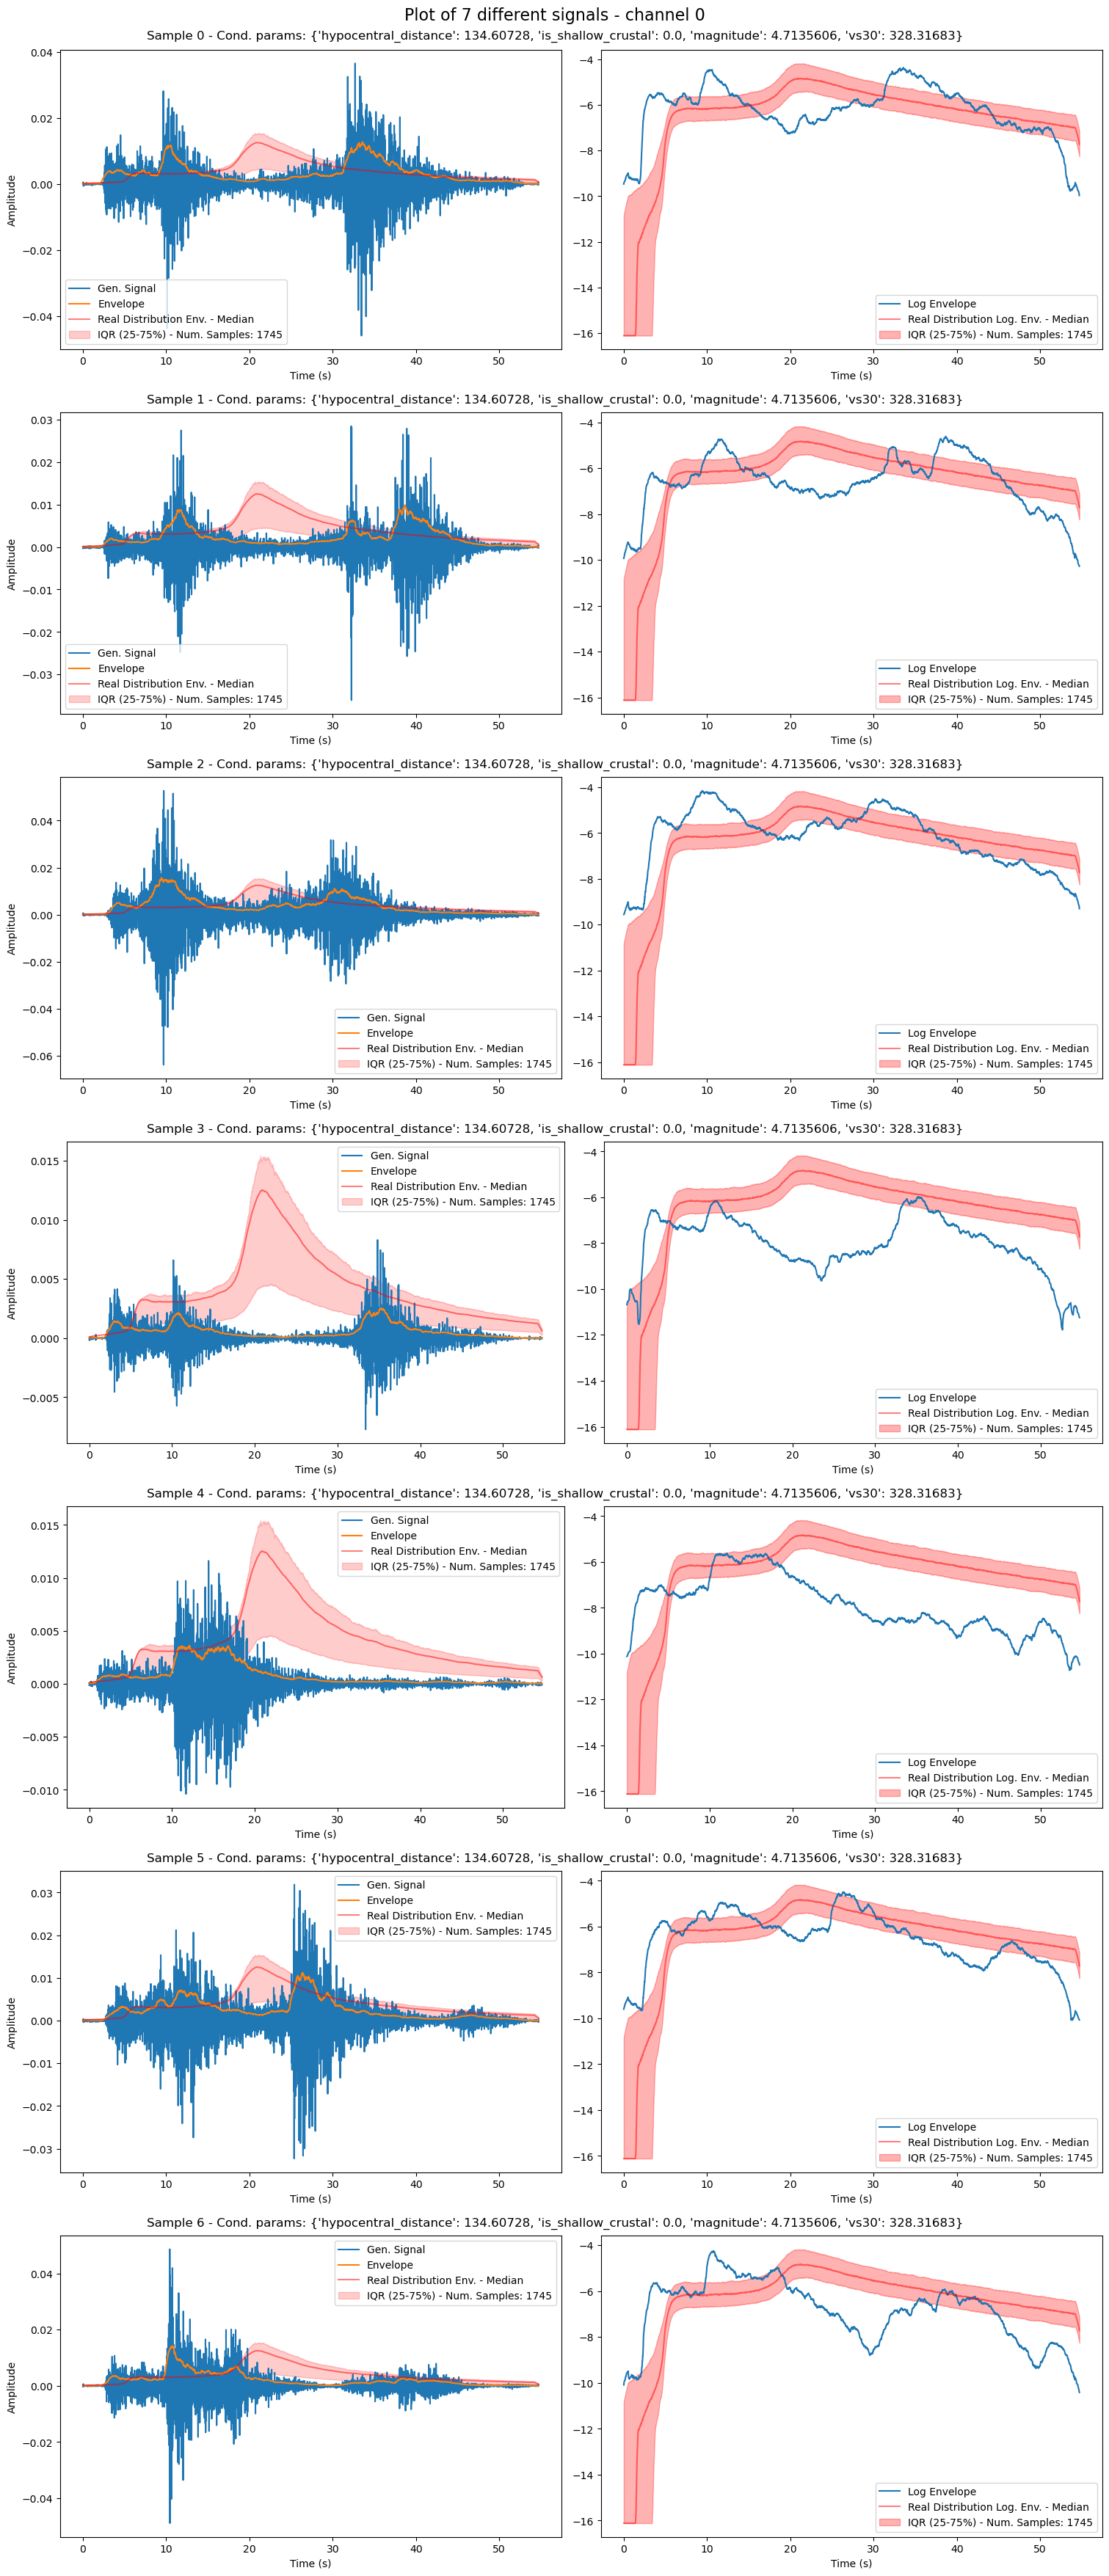

In [28]:
mag_bin = (4, 5)
dist_bin = (120, 150)
data_test_single_bin = test_dataset.get_data_by_bins(mag_bin, dist_bin, is_shallow_crustal=0)
cond_params_mean = np.mean(data_test_single_bin['cond'], axis=0).reshape(1,-1)
data_pred_single_bin = generate_data(model, model_data_representation=model_data_repr, raw_output=False, num_samples=7, cond_input=cond_params_mean, device=device.type, max_batch_size=batch_size)

plot_waveforms(data_pred_single_bin, test_waveforms=data_test_single_bin['waveforms'])

Let's now compare the statistics of the generated data wrt the test data.

In [29]:
# Load Test Data
test_cond = []
test_raw_waveforms = []
num_batches_to_generate = 32
for i, batch in enumerate(test_dataloader):
    if i == num_batches_to_generate:
        break
    test_raw_waveforms.append(to_numpy(batch['representation']))
    test_cond.append(to_numpy(batch['cond']))
test_raw_waveforms = np.concatenate(test_raw_waveforms, axis=0)
test_waveforms = model_data_repr.invert_representation(test_raw_waveforms)
test_cond = np.concatenate(test_cond, axis=0)

test_data = {"waveforms": test_waveforms, "cond": test_cond}

test_waveforms.shape, test_cond.shape    

((4096, 3, 5472), (4096, 4))

Now let's generate more samples to perform an analysis by dividing the data in bins (magnitude and distance). 

In [30]:
# Generate waveforms with the same conditioning parameters of the test data
generated_raw_data = generate_data(model, model_data_repr, raw_output=True, num_samples=test_cond.shape[0], cond_input=test_cond, device=device.type, max_batch_size=batch_size)
generated_raw_data['waveforms'].shape, generated_raw_data['cond'].shape

100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


((4096, 6, 5472), (4096, 4))

Let's check the raw outputs by comparing them statistically with real data in the representation domain. 

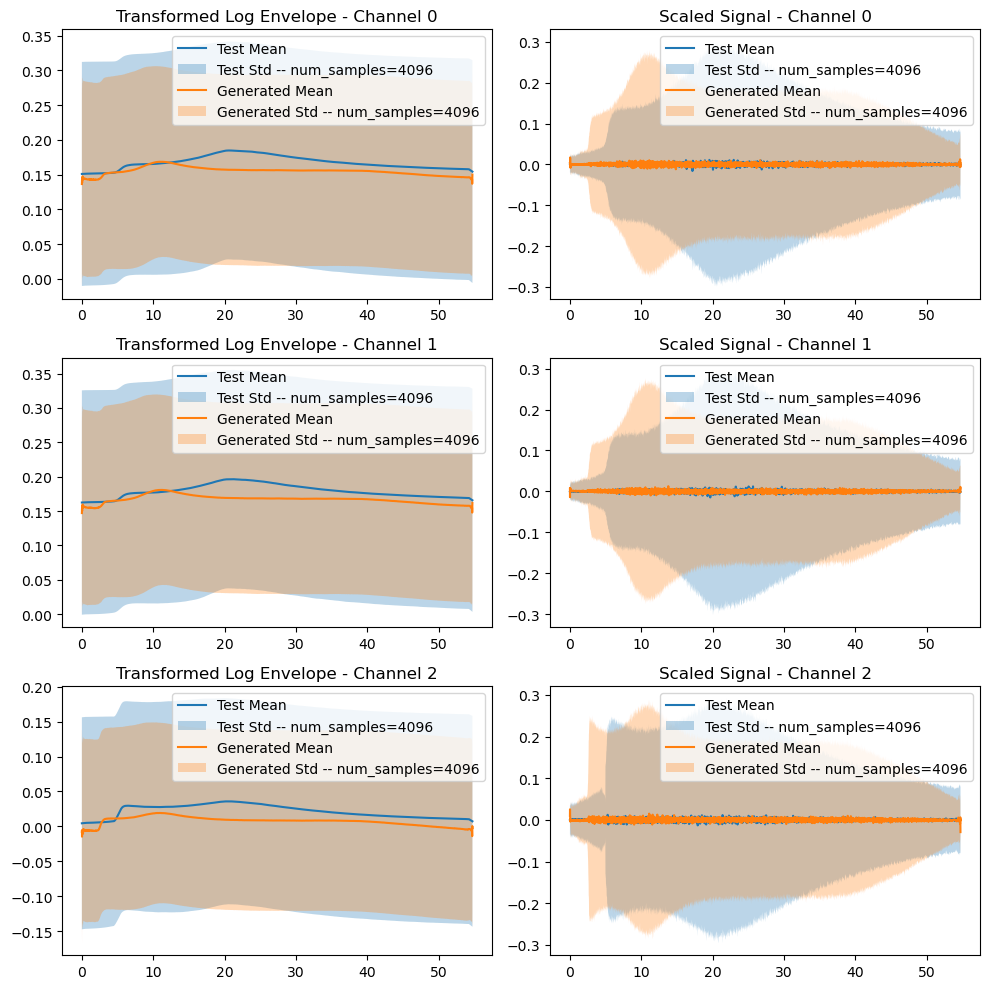

In [31]:
plot_raw_output_distribution(generated_raw_data["waveforms"], test_raw_waveforms, model_data_repr)

In [32]:
generated_data = {"waveforms": model_data_repr.invert_representation(generated_raw_data['waveforms']), "cond": generated_raw_data['cond']}
generated_data['waveforms'].shape, generated_data['cond'].shape

((4096, 3, 5472), (4096, 4))

Let's save the generated data and the test data for future use.

The data will be saved in the same place of the checkpoint of the selected model, with the same name of `ckpt`, except for the extension of the file (saved as a pickle `.pkl` file).
The best way to download the generated dataset locally is to replace `pkl_filename` with the desired filename to store it in the current directory, and then download it using the visual interface of VSCode or JupyterLab. 


The data is saved as a `dict` with keys `waveforms` and `cond`.

In [33]:
import pickle

# If some data is already saved, load it
pkl_filename = f"{str(ckpt).replace('.ckpt', '.pkl')}"
pkl_filepath = Path(pkl_filename)
if os.path.exists(pkl_filepath):
    with open(pkl_filepath,'rb') as f:
        pred_data_f = pickle.load(f)
        if "generated_data" in globals():
            generated_data['waveforms'] = np.concatenate([pred_data_f['waveforms'], generated_data['waveforms']])
            generated_data['cond'] = np.concatenate([pred_data_f['cond'], generated_data['cond']])
        else:
            generated_data = {"waveforms": pred_data_f['waveforms'], "cond": pred_data_f['cond']}
                
test_data['cond'] = generated_data['cond'] 
test_data['waveforms'] = test_dataset.get_waveforms_by_cond_input(generated_data['cond'])

# Store the generated data and the test data        
with open(pkl_filepath,'wb') as f: pickle.dump(generated_data, f)
print(pkl_filepath)
generated_data['waveforms'].shape, generated_data['cond'].shape

../outputs/ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-moving_average_shifted-log-log_offset:1.0e-05-normalize-scalar:True/name=0_epoch=143-val_loss=0.02.pkl


((4096, 3, 5472), (4096, 4))

And let's now compare the generated data against the test ones. 

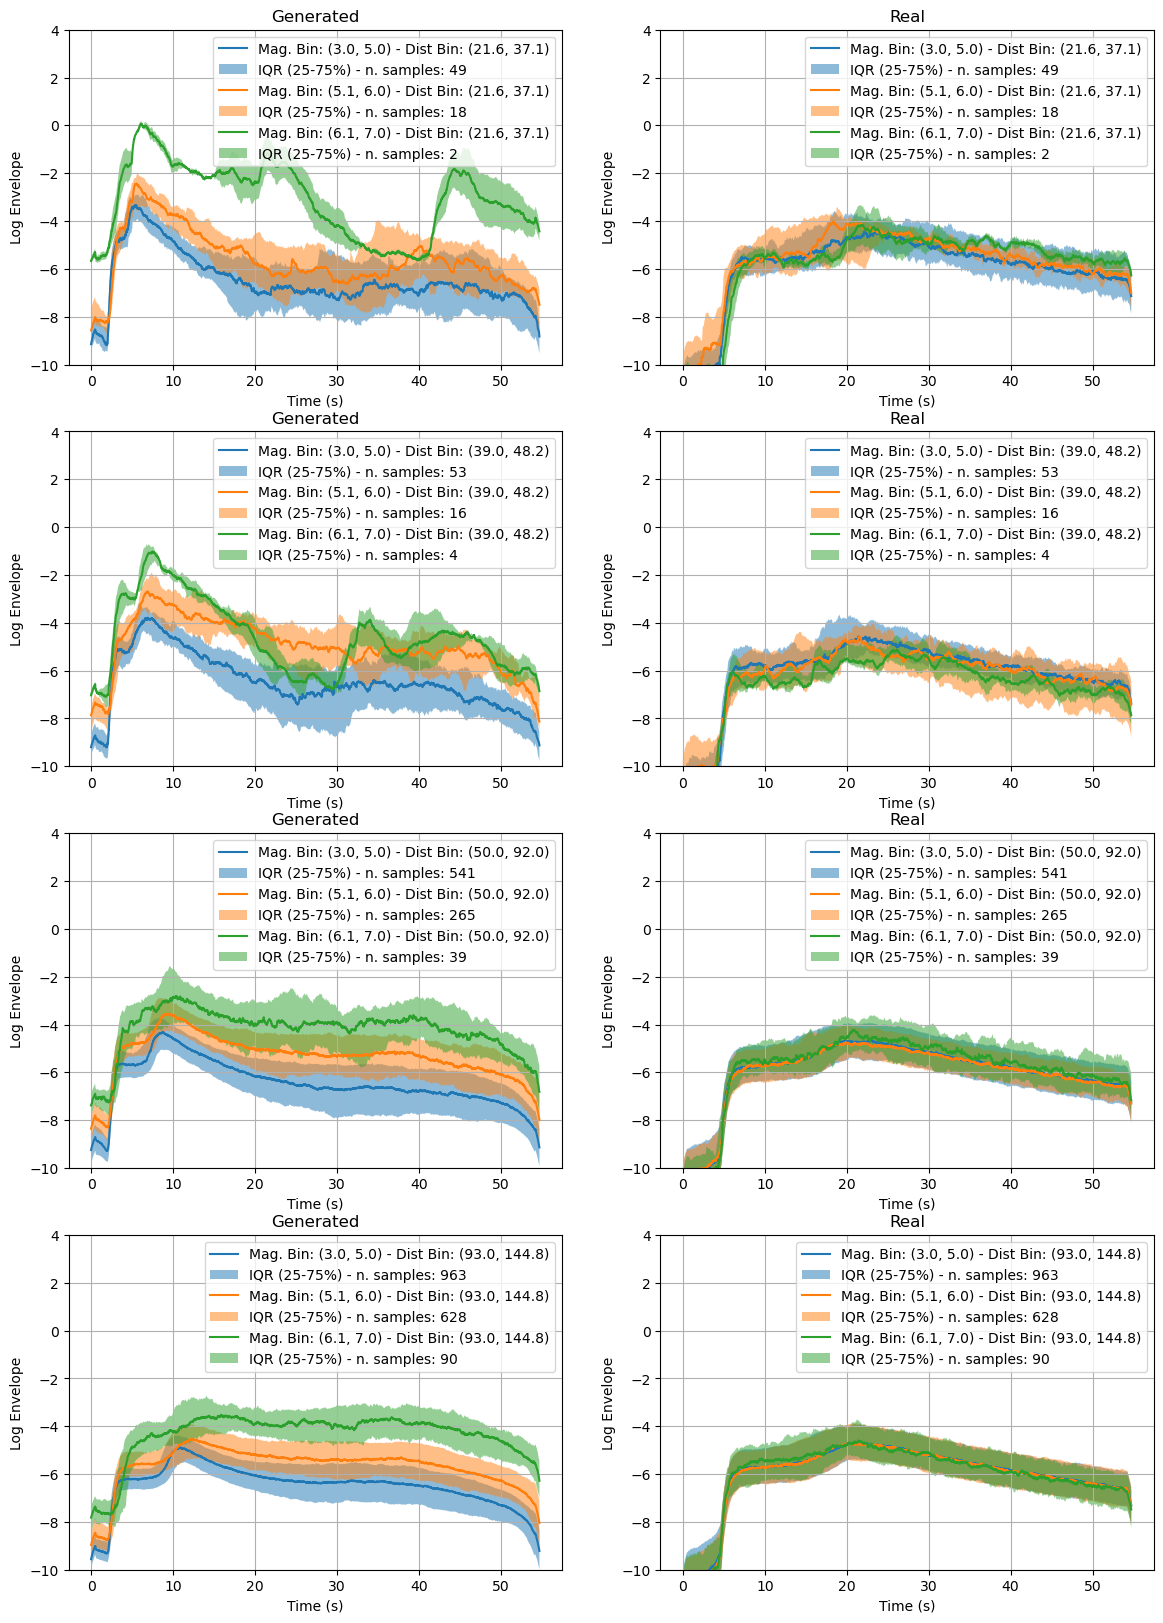

In [34]:
plot_bins(
    plot_type='log_envelope',
    distance_bins = [(21.6, 37.1), (39.0, 48.2), (50.0, 92.0), (93.0, 144.8)],
    magnitude_bins = [(3.0, 5.0), (5.1, 6.0), (6.1, 7.0)], 
    channel_index=0,
    test_data = test_data, 
    data = generated_data, 
    model = model,
     model_data_representation = model_data_repr
)

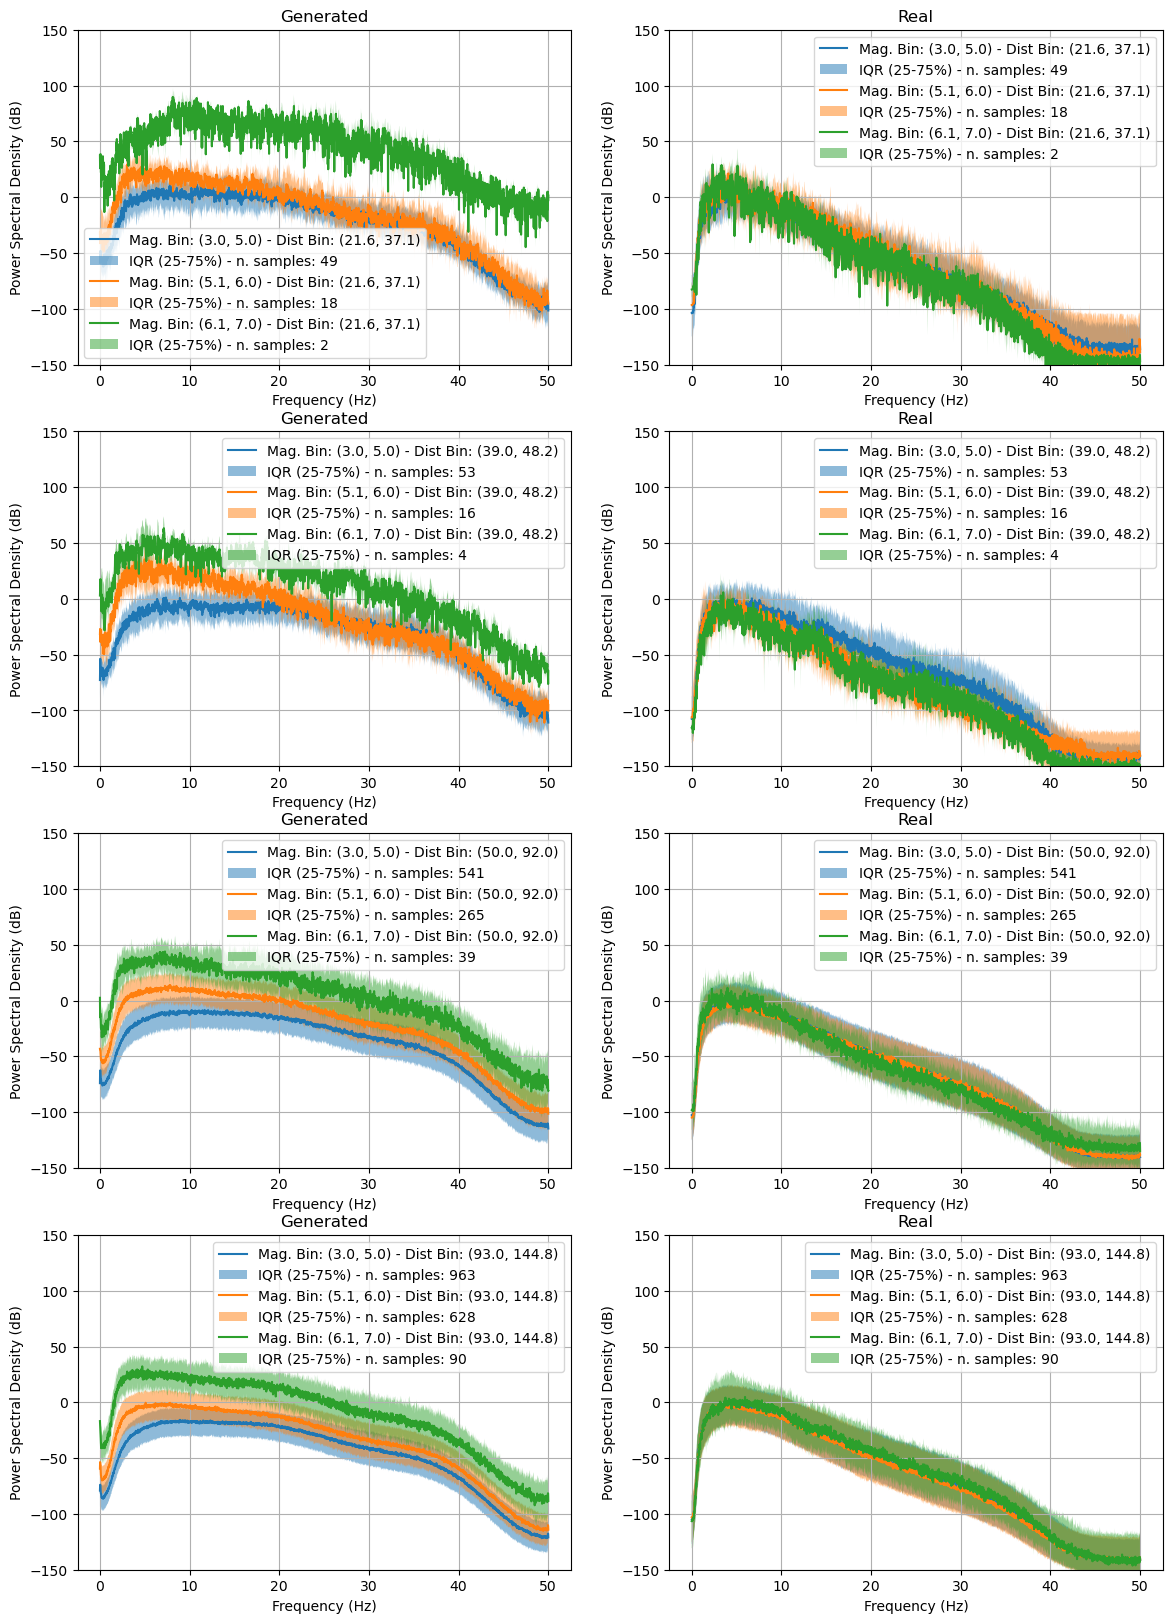

In [35]:
plot_bins(
    plot_type='power_spectral_density',
    distance_bins = [(21.6, 37.1), (39.0, 48.2), (50.0, 92.0), (93.0, 144.8)],
    magnitude_bins = [(3.0, 5.0), (5.1, 6.0), (6.1, 7.0)], 
    channel_index=0,
    test_data = test_data, 
    data = generated_data, 
    model = model,
     model_data_representation = model_data_repr
)

Visualize the whole distribution in terms of Power Spectral Density and Envelope. 

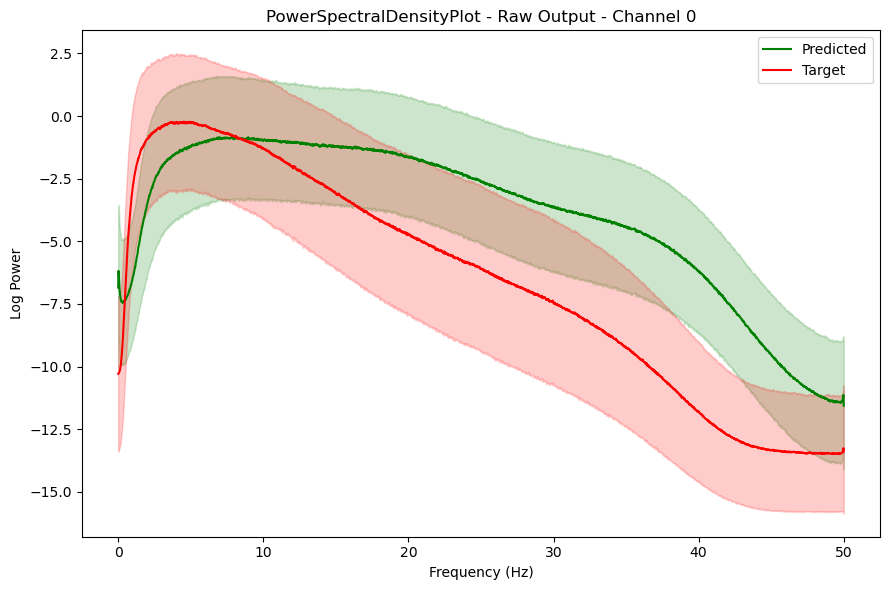

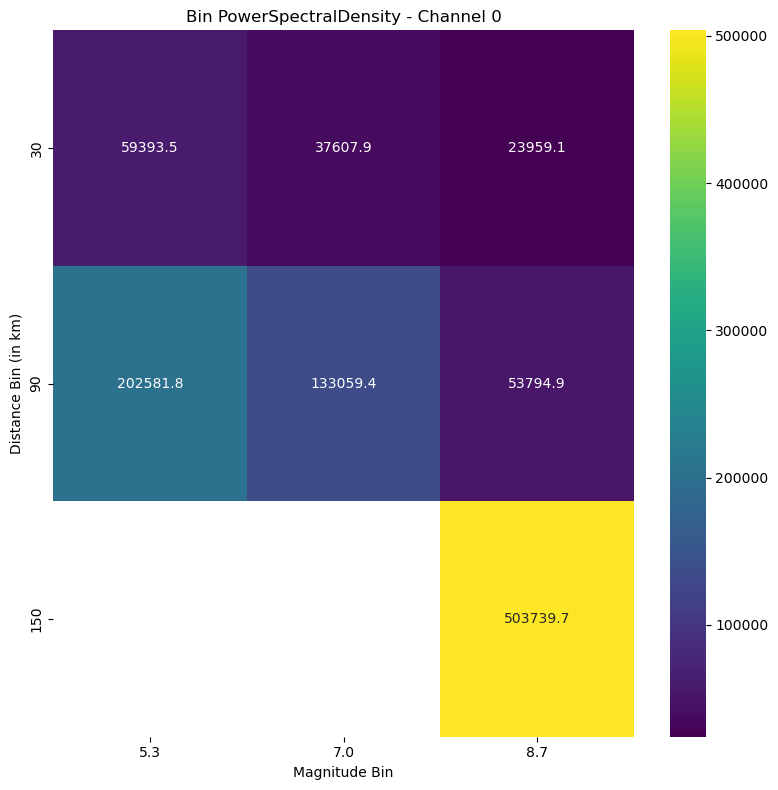

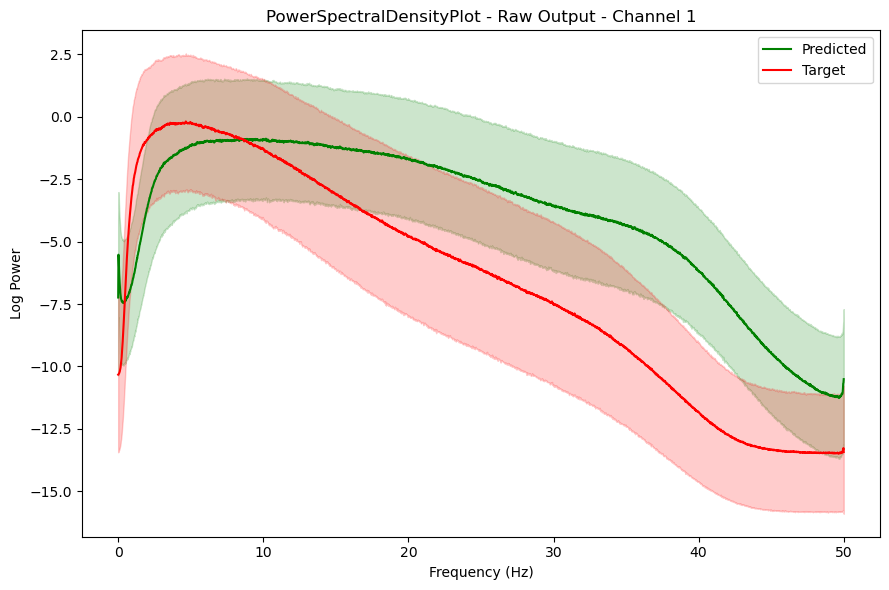

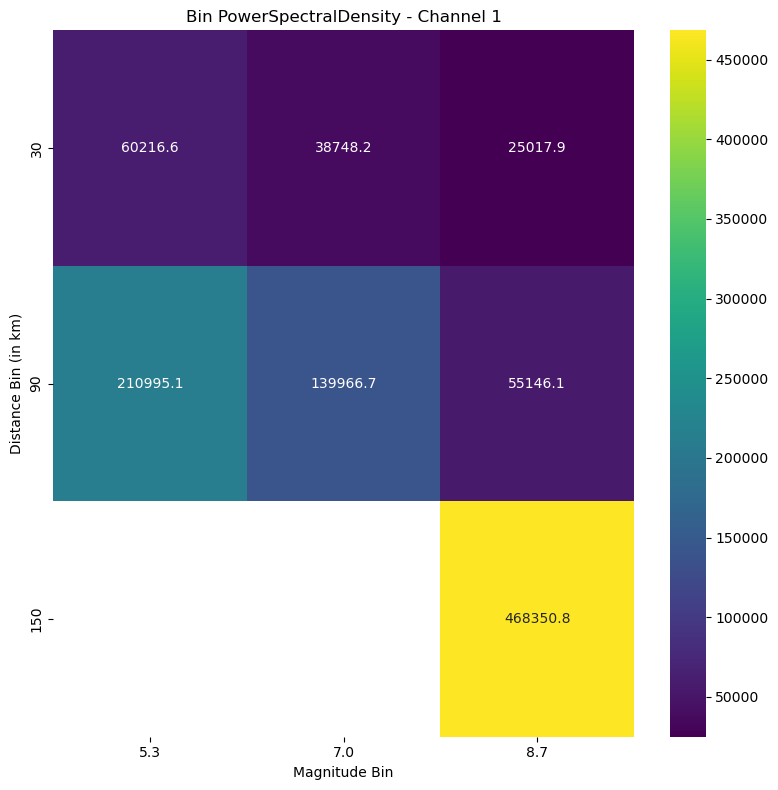

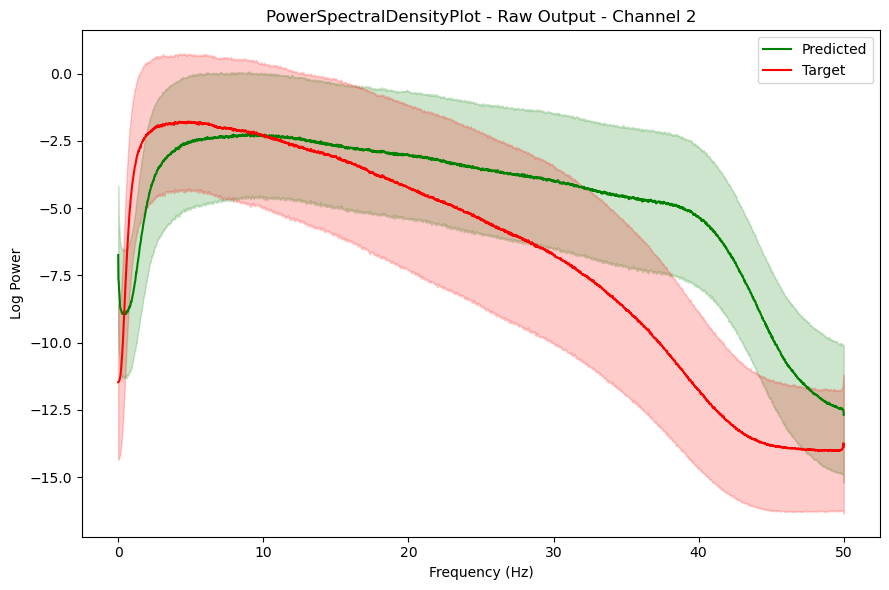

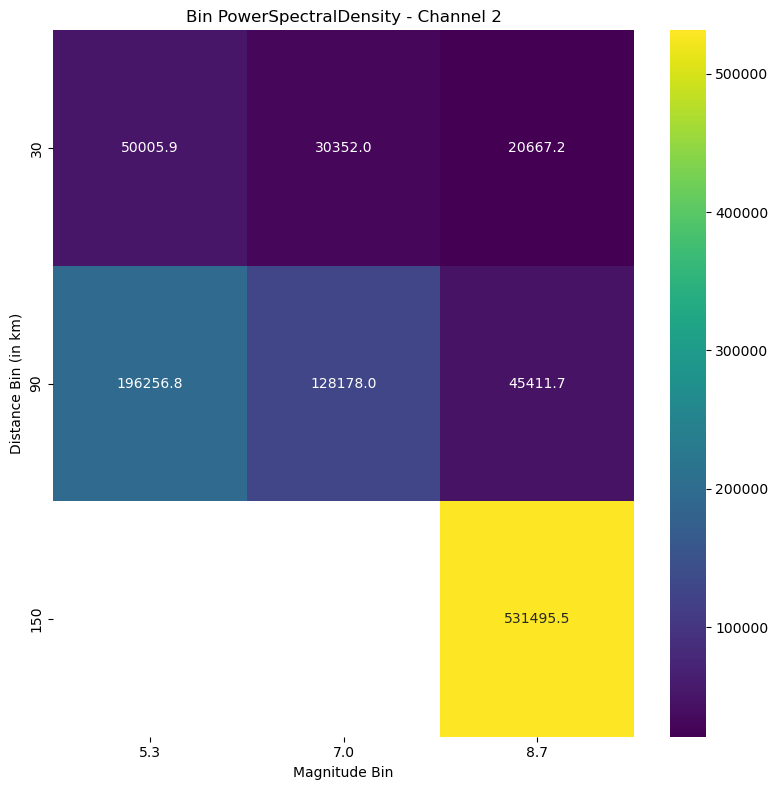

In [36]:
from tqdne.plot import PowerSpectralDensityPlot, BinPlot
from tqdne.metric import PowerSpectralDensity

psd_metrics = [PowerSpectralDensity(fs, channel=channel, invert_representation=False) for channel in range(n_channels)]
psd_plots = [PowerSpectralDensityPlot(fs, channel, invert_representation=False) for channel in range(n_channels)]
for i, psd in enumerate(psd_metrics):
    psd_plots[i](pred=generated_data['waveforms'], target=test_data['waveforms'][:, :, :signal_length], cond=test_data['cond'])
    psd(pred=generated_data['waveforms'], target=test_data['waveforms'][:, :, :signal_length])    
    psd_bin = BinPlot(psd, num_mag_bins=3, num_dist_bins=3)
    psd_bin(pred=generated_data['waveforms'], target=test_data['waveforms'][:, :, :signal_length], cond=test_data['cond']).show()
       

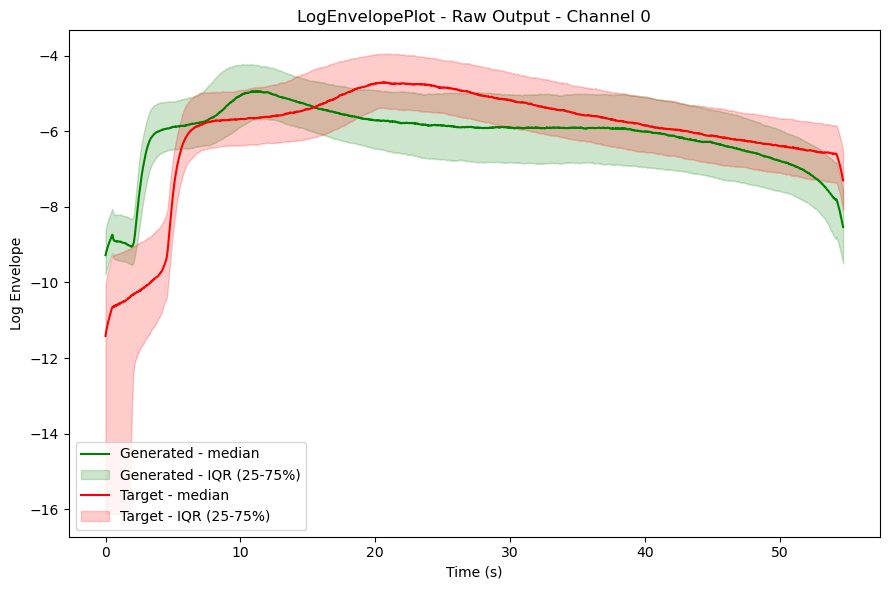

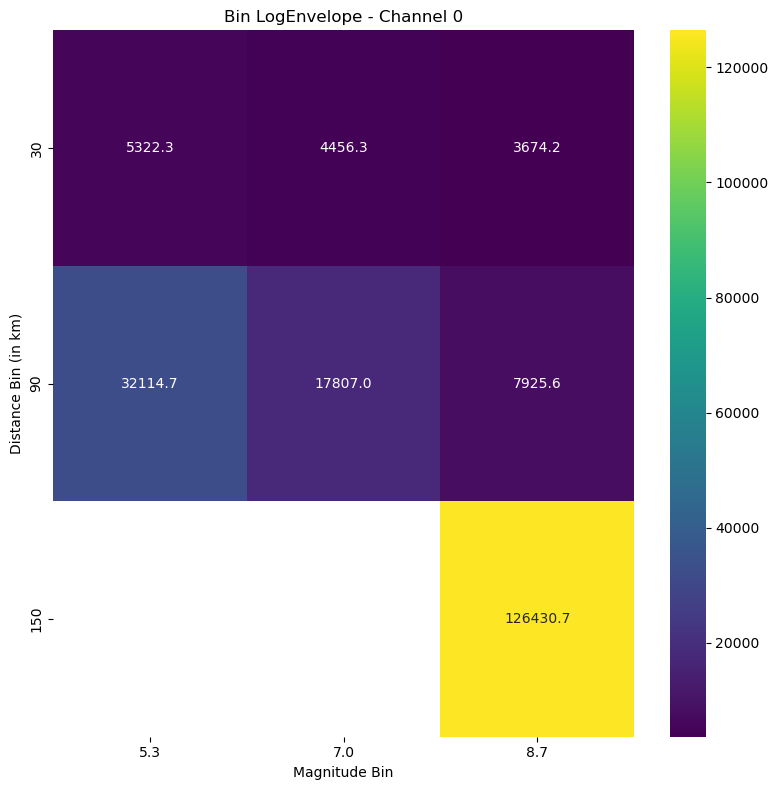

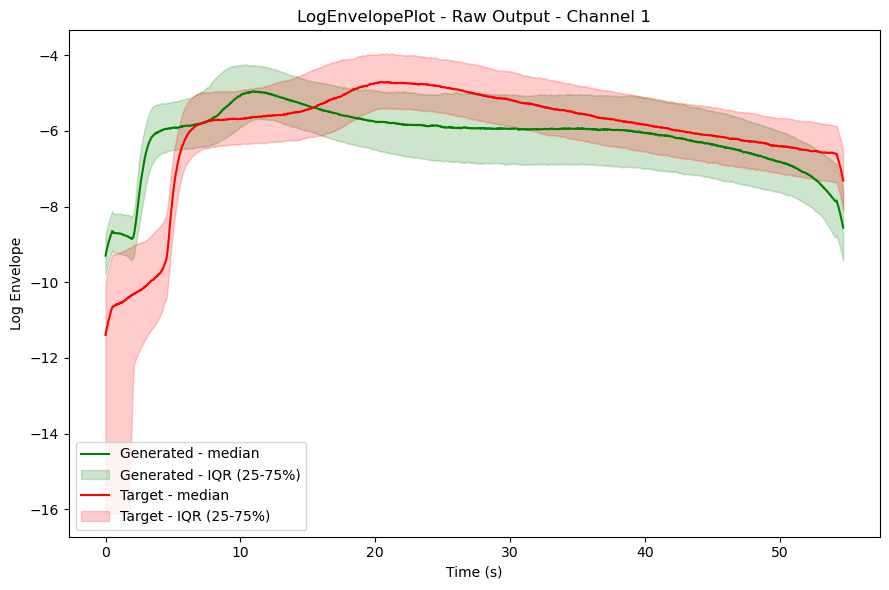

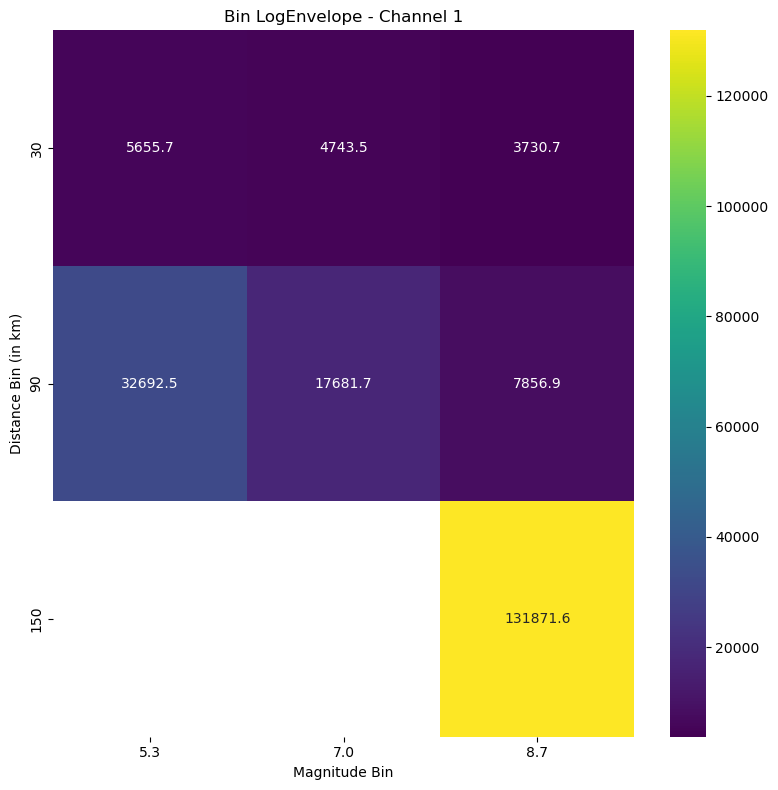

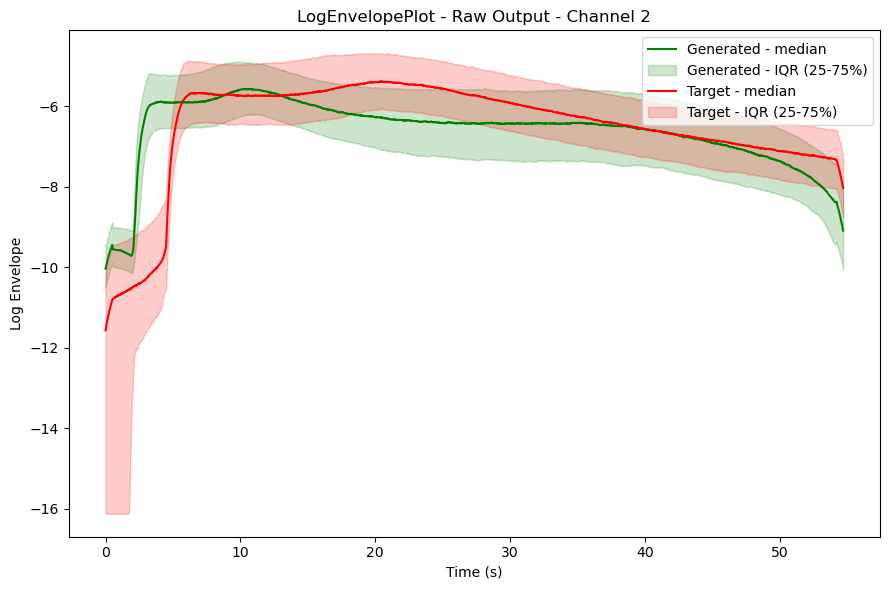

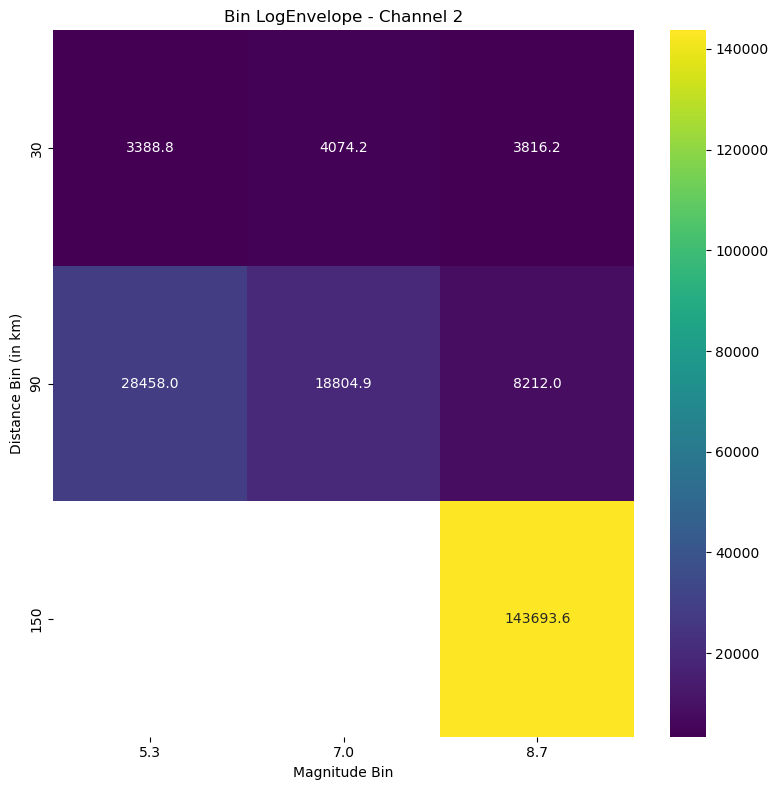

In [37]:
from tqdne.plot import LogEnvelopePlot, BinPlot
from tqdne.metric import LogEnvelope

logenv_metrics = [LogEnvelope(channel=channel, invert_representation=False) for channel in range(n_channels)]
logenv_plots = [LogEnvelopePlot(fs=fs, channel=channel, invert_representation=False) for channel in range(n_channels)]
for i, logenv in enumerate(logenv_metrics):
    logenv_plots[i](pred=generated_data['waveforms'], target=test_data['waveforms'][:, :, :signal_length], cond=test_data['cond'])
    logenv(pred=generated_data['waveforms'], target=test_data['waveforms'][:, :, :signal_length])    
    logenv_bin = BinPlot(logenv, num_mag_bins=3, num_dist_bins=3)
    logenv_bin(pred=generated_data['waveforms'], target=test_data['waveforms'][:, :, :signal_length], cond=test_data['cond']).show()

## TODOs

In [38]:
# TODO: widgets do not work

# from tqdne.metric import PowerSpectralDensity, BinMetric
# import ipywidgets as widgets
# from functools import partial

# metrics = {"Power Spectral Density": partial(PowerSpectralDensity, fs=config.fs)}

# # Create a dropdown for selecting the metric
# metric_dropdown = widgets.Dropdown(
#     options=metrics.keys(),
#     description='Metric:',
# )

# # Create a slider for selecting the channel
# channel_slider = widgets.IntSlider(
#     value=0,
#     min=0,
#     max=2,
#     step=1,
#     description='Channel:',
#     disabled=False,
#     continuous_update=False,
#     orientation='horizontal',
#     readout=True,
#     readout_format='d'
# )


# # Bin plot checkbox
# bin_plot_checkbox = widgets.Checkbox(
#     value=False,
#     description='Plot bins',
#     disabled=False,
#     indent=True,
# )

# # Create a slider for selecting the number of bins
# num_bins_slider = widgets.IntSlider(
#     value=10,
#     min=1,
#     max=50,
#     step=1,
#     description='Num bins:',
#     disabled=False,
#     continuous_update=False,
#     orientation='horizontal',
#     readout=True,
#     readout_format='d'
# )

# # Function to update the plot
# def update_plot(metric_name, bin_plot, num_bins=10, channel=0):
#     metric = metrics[metric_name](channel=channel)
#     if bin_plot:
#         metric = BinMetric(metric, num_mag_bins=num_bins, num_dist_bins=num_bins)

#     # Compute the metric
#     metric.reset()
#     metric.update(pred={"generated": pred_waveforms}, target={"representation": test_waveforms[:, :, : pred_waveforms.shape[-1]], "cond": test_features})
#     metric.plot().show()

# # Create interactive plot
# widgets.interact(update_plot, metric_name=metric_dropdown, channel=channel_slider, bin_plot=bin_plot_checkbox, num_bins=num_bins_slider)



In [39]:
print('done')

done


In [40]:
# # Save the data to obspy format
# from obspy import Stream, Trace

# # Convert waveforms to Trace objects
# traces = [Trace(data=waveform, header={k:v for k, v in get_cond_params_dict(pred_data["cond"][i])}) for i, waveform in enumerate(pred_data["waveforms"])]

# # Create a Stream object
# st = Stream(traces=traces)

# # Save the Stream object to a file
# st.write("generated_waveforms.mseed", format="MSEED", reclen=512, encoding="FLOAT64")
